# TFR Factors Computation

In [1]:
#import relevant packages
import pandas as pd, numpy as np, os, warnings, datetime
import matplotlib.pyplot as plt, seaborn as sns

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
#specify data/output path
data_path = 'Z:/PL43_TFR/Cleaned Data/'
output_path = 'Z:/PL43_TFR/Cleaned Data/Output/'

## Stations

In [3]:
#county names to identify station counties
counties = pd.read_csv(data_path + 'counties.csv')
counties.head(2)

,Number,County,District
0,1,Adair,8
1,2,Allen,3


In [4]:
#clean up stations
station_stats = pd.read_parquet(data_path + 'stations_stats_complete_clean_updated.parquet')
station_stats['FC_New'] = station_stats['FC_New'].astype(int)
station_stats['FC_Old'] = station_stats['FC_Old'].astype(int)
station_stats['Number'] = station_stats['Station'].str[:3].astype(int)
station_stats['Route'] = station_stats['RT_UNIQUE'].apply(lambda x: '-'.join(x.split('-')[1:3]))
station_stats.head(2)

,Station,Vol_Obs,Vol_Total,Vol_Complete,Vol_Clean,Class_Obs,Class_Total,Class_Complete,Class_Clean,RT_UNIQUE,MP,FC_New,FC_Old,Number,Route
0,001P34,3282.0,3652.0,89.87,89.70,11856.0,87648.0,13.53,13.53,001-KY-0080 -000,20.05,5,7,1,KY-0080
1,005P71,7096.0,7304.0,97.15,97.04,154716.0,175296.0,88.26,87.79,005-LN-9008 -000,10.10,2,12,5,LN-9008


In [5]:
station_stats = pd.merge(station_stats, counties, on='Number', how='left')
stations = station_stats[['Station', 'Vol_Clean','County', 'Route', 'MP', 'FC_Old', 'FC_New']]
stations.head()

,Station,Vol_Clean,County,Route,MP,FC_Old,FC_New
0,001P34,89.70,Adair,KY-0080,20.05,7,5
1,005P71,97.04,Barren,LN-9008,10.10,12,2
2,007P31,81.00,Bell,US-0025E,18.20,2,3
3,008P63,45.02,Boone,I -0075,176.00,11,1
4,009P26,93.21,Bourbon,US-0068,3.85,14,3


## Traffic volume data aggregation

### Get number of times of each day of week occurs in each month in each calendar year

In [6]:
years = list(range(2017,2022))
months = list(range(1,13))
dow = list(range(0,7))

In [7]:
import calendar
from datetime import datetime
yr = []
month = []
wday = []
numdays = []
mrange = []
weekdays = []
weekends = []
for i in years:
    for j in months:
        wkdays = 0
        wkends = 0
        for k in dow:
            yr.append(i)
            month.append(j)
            mrange.append(calendar.monthrange(i, j)[1])
            wday.append(k)
            nd = len([1 for l in calendar.monthcalendar(i,j) if l[k] != 0])
            numdays.append(nd)
            if k < 5:
                wkdays += nd
            else:
                wkends += nd
        weekdays.extend([wkdays]*7)
        weekends.extend([wkends]*7)

In [8]:
# put the results of the analysis into a dtaframe
wjm = pd.DataFrame(data = {'Year':yr, 'Month':month, 'dow':wday, 'ndays_month':mrange, 
                           'nwkdays': weekdays, 'nwkends': weekends, 'W_jm':numdays})
wjm.head(8)

,Year,Month,dow,ndays_month,nwkdays,nwkends,W_jm
0,2017,1,0,31,22,9,5
1,2017,1,1,31,22,9,5
2,2017,1,2,31,22,9,4
3,2017,1,3,31,22,9,4
4,2017,1,4,31,22,9,4
5,2017,1,5,31,22,9,4
6,2017,1,6,31,22,9,5
7,2017,2,0,28,20,8,4


### volume data prep

In [9]:
volume_data = pd.read_parquet(data_path + 'volume_5years_clean_transposed_by_hour_with_date.parquet')
#convert data from string to data type "datetime"
volume_data['date'] = volume_data['date'].astype('datetime64[ns]')
#get day of week from datetime
volume_data['dow'] = volume_data['date'].dt.dayofweek
#create a new column to check if day of week is a weekend
volume_data['weekend'] = volume_data['dow'].map(lambda x: 1 if x>4 else 0)
volume_data.head()

,Station,Dir,Year,Month,Day,LaneID,Count,Hour,date,dow,weekend
0,001P34,3,2017,1,1,1,24,0,2017-01-01,6,1
1,001P34,7,2017,1,1,1,33,0,2017-01-01,6,1
2,001P34,3,2017,1,2,1,6,0,2017-01-02,0,0
3,001P34,7,2017,1,2,1,4,0,2017-01-02,0,0
4,001P34,3,2017,1,3,1,6,0,2017-01-03,1,0


In [10]:
#check if null values present in data columns
volume_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10210920 entries, 0 to 10210919
Data columns (total 11 columns):
 #   Column   Non-Null Count     Dtype         
---  ------   --------------     -----         
 0   Station  10210920 non-null  object        
 1   Dir      10210920 non-null  int32         
 2   Year     10210920 non-null  int32         
 3   Month    10210920 non-null  int32         
 4   Day      10210920 non-null  int32         
 5   LaneID   10210920 non-null  int32         
 6   Count    10210920 non-null  int32         
 7   Hour     10210920 non-null  int64         
 8   date     10210920 non-null  datetime64[ns]
 9   dow      10210920 non-null  int64         
 10  weekend  10210920 non-null  int64         
dtypes: datetime64[ns](1), int32(6), int64(3), object(1)
memory usage: 623.2+ MB


In [11]:
#no null values present. don't need to worry about null values. 
volume_data.LaneID.unique()

array([1, 2, 3, 4, 0, 5])

### MADT_m / AADT computation

In [12]:
unique_value = lambda x: x.unique()[0]  
nhjm = lambda x: len(x.unique()) # number of times hour has data for dow (range between 1 to 5)

In [13]:
%%time
#sum volume across lanes and direction.
volume_agg = volume_data.groupby(['Station','Year', 'Month', 'dow','Hour'], as_index=False).agg({
                                                                                    'Count':'sum',
                                                                                    'weekend':unique_value,
                                                                                    'Day': 'nunique',})
volume_agg.head()

CPU times: total: 26 s
Wall time: 31 s


,Station,Year,Month,dow,Hour,Count,weekend,Day
0,001P34,2017,1,0,0,41,0,5
1,001P34,2017,1,0,1,26,0,5
2,001P34,2017,1,0,2,40,0,5
3,001P34,2017,1,0,3,106,0,5
4,001P34,2017,1,0,4,128,0,5


In [14]:
volume_agg.columns = ['Station', 'Year', 'Month', 'dow', 'hour', 'VOL_ihjm', 'weekend', 'N_hjm']
volume_agg.head()

,Station,Year,Month,dow,hour,VOL_ihjm,weekend,N_hjm
0,001P34,2017,1,0,0,41,0,5
1,001P34,2017,1,0,1,26,0,5
2,001P34,2017,1,0,2,40,0,5
3,001P34,2017,1,0,3,106,0,5
4,001P34,2017,1,0,4,128,0,5


In [15]:
#average hourly volume for each day of week (dow) in a month
volume_agg['VOL_ihjm_over_N_hjm'] = volume_agg['VOL_ihjm']/volume_agg['N_hjm']
volume_agg.head()

,Station,Year,Month,dow,hour,VOL_ihjm,weekend,N_hjm,VOL_ihjm_over_N_hjm
0,001P34,2017,1,0,0,41,0,5,8.2
1,001P34,2017,1,0,1,26,0,5,5.2
2,001P34,2017,1,0,2,40,0,5,8.0
3,001P34,2017,1,0,3,106,0,5,21.2
4,001P34,2017,1,0,4,128,0,5,25.6


In [16]:
#merge with the number of times each dow occurs in month in each calendar year (Wjm in TMG MADT equation)
volume_agg_wjm = pd.merge(volume_agg, wjm, on=['Year', 'Month', 'dow'], how = 'left')
volume_agg_wjm.head()

,Station,Year,Month,dow,hour,VOL_ihjm,weekend,N_hjm,VOL_ihjm_over_N_hjm,ndays_month,nwkdays,nwkends,W_jm
0,001P34,2017,1,0,0,41,0,5,8.2,31,22,9,5
1,001P34,2017,1,0,1,26,0,5,5.2,31,22,9,5
2,001P34,2017,1,0,2,40,0,5,8.0,31,22,9,5
3,001P34,2017,1,0,3,106,0,5,21.2,31,22,9,5
4,001P34,2017,1,0,4,128,0,5,25.6,31,22,9,5


In [17]:
#check if merge is correctly done
print(len(volume_agg) == len(volume_agg_wjm))   
print(len(volume_agg_wjm[pd.isnull(volume_agg_wjm['W_jm'])]))

# Xu: Also a good practice to check if any joined columns is null

#Eugene:
# I usually also print out the information on columns like this: "volume_agg_wjm.info()" and then delete after

True
0


In [18]:
volume_agg_wjm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714648 entries, 0 to 714647
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Station              714648 non-null  object 
 1   Year                 714648 non-null  int32  
 2   Month                714648 non-null  int32  
 3   dow                  714648 non-null  int64  
 4   hour                 714648 non-null  int64  
 5   VOL_ihjm             714648 non-null  int32  
 6   weekend              714648 non-null  int64  
 7   N_hjm                714648 non-null  int64  
 8   VOL_ihjm_over_N_hjm  714648 non-null  float64
 9   ndays_month          714648 non-null  int64  
 10  nwkdays              714648 non-null  int64  
 11  nwkends              714648 non-null  int64  
 12  W_jm                 714648 non-null  int64  
dtypes: float64(1), int32(3), int64(8), object(1)
memory usage: 68.2+ MB


In [19]:
#sum across hours. (summation h=1 to 24 in TMG MADT equation)
volume_agg_mdow = volume_agg_wjm.groupby(['Station', 'Year', 'Month', 'dow'], as_index=False).agg({
                                                                            'hour':'count',
                                                                            'VOL_ihjm_over_N_hjm':'sum',
                                                                            'weekend': unique_value,
                                                                            'W_jm' : unique_value,
                                                                            'nwkdays':unique_value,
                                                                            'nwkends':unique_value,
                                                                            'ndays_month' : unique_value
})

volume_agg_mdow.columns = ['Station','Year','Month','dow','num_hours','VOL_jm','weekend','W_jm','nwkdays','nwkends','ndaysinMonth']
volume_agg_mdow.head(8)

,Station,Year,Month,dow,num_hours,VOL_jm,weekend,W_jm,nwkdays,nwkends,ndaysinMonth
0,001P34,2017,1,0,24,2522.40,0,5,22,9,31
1,001P34,2017,1,1,24,2789.80,0,5,22,9,31
2,001P34,2017,1,2,24,2891.25,0,4,22,9,31
3,001P34,2017,1,3,24,2671.25,0,4,22,9,31
4,001P34,2017,1,4,24,2851.50,0,4,22,9,31
5,001P34,2017,1,5,24,2271.75,1,4,22,9,31
6,001P34,2017,1,6,24,1963.00,1,5,22,9,31
7,001P34,2017,2,0,24,2838.50,0,4,20,8,28


In [20]:
# apply weighting factor for the number of times the jth day of week occurs in the mth month
volume_agg_mdow['VOL_jm_times_W_jm'] = volume_agg_mdow['W_jm'] * volume_agg_mdow['VOL_jm']
volume_agg_mdow.head()

,Station,Year,Month,dow,num_hours,VOL_jm,weekend,W_jm,nwkdays,nwkends,ndaysinMonth,VOL_jm_times_W_jm
0,001P34,2017,1,0,24,2522.40,0,5,22,9,31,12612.0
1,001P34,2017,1,1,24,2789.80,0,5,22,9,31,13949.0
2,001P34,2017,1,2,24,2891.25,0,4,22,9,31,11565.0
3,001P34,2017,1,3,24,2671.25,0,4,22,9,31,10685.0
4,001P34,2017,1,4,24,2851.50,0,4,22,9,31,11406.0


In [21]:
volume_agg_mn = volume_agg_mdow.groupby(['Station', 'Year', 'Month'], as_index=False).agg({'dow':'count',
                                                                           'W_jm':'sum',
                                                                           'ndaysinMonth':unique_value,
                                                                           'VOL_jm_times_W_jm':'sum'})

volume_agg_mn.columns = ['Station','Year', 'Month', 'num_dow', 'sum_Wjm', 'ndaysinMonth', 'sum_VOL_jm_times_W_jm']

volume_agg_mn['MADTm'] = volume_agg_mn['sum_VOL_jm_times_W_jm']/volume_agg_mn['ndaysinMonth']
volume_agg_mn['dm_times_MADTm']  = volume_agg_mn['ndaysinMonth'] * volume_agg_mn['MADTm']
volume_agg_mn.head()

,Station,Year,Month,num_dow,sum_Wjm,ndaysinMonth,sum_VOL_jm_times_W_jm,MADTm,dm_times_MADTm
0,001P34,2017,1,7,31,31,79119.0,2552.225806,79119.0
1,001P34,2017,2,7,28,28,79629.0,2843.892857,79629.0
2,001P34,2017,3,7,31,31,89221.0,2878.096774,89221.0
3,001P34,2017,4,7,30,30,88393.0,2946.433333,88393.0
4,001P34,2017,5,7,31,31,91200.0,2941.935484,91200.0


In [22]:
AADTy = volume_agg_mn.groupby(['Station','Year'], as_index=False).agg({'Month':'count',
                                                                       'dm_times_MADTm':'sum',
                                                                       'ndaysinMonth': 'sum'})
AADTy.columns = ['Station','Year', 'numMonths', 'sum_dm_times_MADTm', 'sum_ndaysinMonth']
AADTy['AADT'] = AADTy['sum_dm_times_MADTm']/AADTy['sum_ndaysinMonth']
AADTy.head()

,Station,Year,numMonths,sum_dm_times_MADTm,sum_ndaysinMonth,AADT
0,001P34,2017,12,1.048154e+06,365,2871.653653
1,001P34,2018,12,1.020301e+06,365,2795.344749
2,001P34,2019,11,9.419930e+05,335,2811.919403
3,001P34,2020,12,9.481262e+05,366,2590.508652
4,001P34,2021,12,9.971291e+05,365,2731.860502


In [23]:
#### some station-years have less than 12 months of data
AADTy[AADTy.numMonths < 12]

,Station,Year,numMonths,sum_dm_times_MADTm,sum_ndaysinMonth,AADT
2,001P34,2019,11,9.419930e+05,335,2811.919403
10,007P31,2017,11,3.631712e+06,334,10873.389970
12,007P31,2019,10,3.049220e+06,303,10063.433718
14,007P31,2021,11,3.380051e+06,334,10119.912425
15,008P63,2017,11,3.972272e+07,334,118930.299401
...,...,...,...,...,...,...
385,120P53,2017,11,7.595343e+06,337,22538.111029
386,120P53,2018,11,6.666664e+06,335,19900.488557
387,120P53,2019,11,7.658636e+06,334,22930.047405
388,120P53,2020,9,5.210562e+06,274,19016.649635


### K-FACTOR / D-FACTOR

In [24]:
#sum volume data across lanes and direction.
volume_agg = volume_data.groupby(['Station','Year', 'Month', 'dow','Hour'], as_index=False).agg({
                                                                                    'Count':'sum',
                                                                                    'weekend':unique_value,
                                                                                    'Day': 'nunique'})

In [25]:
# Sum volume data across lanes for each date in data but keep directions separate (to be used for d-factor calculation)
yrhr_volume_dir = volume_data.groupby(['Station', 'Dir' ,'Year', 'Month', 'Day', 'Hour'], as_index=False).agg({
                                                                                                        'Count':'sum'
})
yrhr_volume_dir.head()

,Station,Dir,Year,Month,Day,Hour,Count
0,001P34,3,2017,1,1,0,24
1,001P34,3,2017,1,1,1,15
2,001P34,3,2017,1,1,2,6
3,001P34,3,2017,1,1,3,5
4,001P34,3,2017,1,1,4,12


In [26]:
#create new string column to help identify 30th highest hour volume date and hour for d-factor analysis
yrhr_volume_dir['idcol'] = yrhr_volume_dir.Station+'_'+yrhr_volume_dir.Year.astype(str)+'_'+\
                           yrhr_volume_dir.Month.astype(str)+'_'+yrhr_volume_dir.Day.astype(str)+'_'+\
                           yrhr_volume_dir.Hour.astype(str)
yrhr_volume_dir.head(1)

,Station,Dir,Year,Month,Day,Hour,Count,idcol
0,001P34,3,2017,1,1,0,24,001P34_2017_1_1_0


In [27]:
# also sum across lane and direction for each date in data (for k-factor)
yrhr_volume = yrhr_volume_dir.groupby(['Station', 'Year', 'Month', 'Day', 'Hour'], as_index=False).agg({'Count':'sum',
                                                                                                        'Dir': 'count'   
})
yrhr_volume.columns = ['Station', 'Year', 'Month', 'Day', 'Hour', 'hourly_volume', 'num_directions']
yrhr_volume.head()

,Station,Year,Month,Day,Hour,hourly_volume,num_directions
0,001P34,2017,1,1,0,57,2
1,001P34,2017,1,1,1,31,2
2,001P34,2017,1,1,2,10,2
3,001P34,2017,1,1,3,11,2
4,001P34,2017,1,1,4,16,2


In [28]:
#create new string column to help identify 30th highest hour volume date and hour for d-factor analysis
yrhr_volume['idcol'] = yrhr_volume.Station+'_'+yrhr_volume.Year.astype(str)+'_'+yrhr_volume.Month.astype(str)+'_'+\
                       yrhr_volume.Day.astype(str)+'_'+yrhr_volume.Hour.astype(str)
yrhr_volume.head()

,Station,Year,Month,Day,Hour,hourly_volume,num_directions,idcol
0,001P34,2017,1,1,0,57,2,001P34_2017_1_1_0
1,001P34,2017,1,1,1,31,2,001P34_2017_1_1_1
2,001P34,2017,1,1,2,10,2,001P34_2017_1_1_2
3,001P34,2017,1,1,3,11,2,001P34_2017_1_1_3
4,001P34,2017,1,1,4,16,2,001P34_2017_1_1_4


In [29]:
yrhr_volume['k_id_index'] = yrhr_volume.index
yrhr_volume.head()

,Station,Year,Month,Day,Hour,hourly_volume,num_directions,idcol,k_id_index
0,001P34,2017,1,1,0,57,2,001P34_2017_1_1_0,0
1,001P34,2017,1,1,1,31,2,001P34_2017_1_1_1,1
2,001P34,2017,1,1,2,10,2,001P34_2017_1_1_2,2
3,001P34,2017,1,1,3,11,2,001P34_2017_1_1_3,3
4,001P34,2017,1,1,4,16,2,001P34_2017_1_1_4,4


In [30]:
#30th highest hourly volume (K-30) and its index
k30_hvol = lambda x: x.nlargest(30).iloc[-1]
k30_hvol_index = lambda x: x.nlargest(30).index[-1]  

In [31]:
kd_factors = yrhr_volume.groupby(['Station', 'Year'], as_index=False).agg({'hourly_volume':['count',
                                                                                            k30_hvol,k30_hvol_index],
                                                                            })
kd_factors.columns = ['Station', 'Year', 'hour_data_count', 'k_30', 'k_30_index']
kd_factors.head()

,Station,Year,hour_data_count,k_30,k_30_index
0,001P34,2017,8376,335,2799
1,001P34,2018,7320,322,9804
2,001P34,2019,6384,315,20655
3,001P34,2020,8616,310,22265
4,001P34,2021,8616,323,37719


In [32]:
kd_factors = pd.merge(kd_factors, 
         yrhr_volume[['k_id_index', 'idcol']],
         left_on = ['k_30_index'], right_on = ['k_id_index'], how='left')

kd_factors.tail()

,Station,Year,hour_data_count,k_30,k_30_index,k_id_index,idcol
390,120P60,2017,7824,1893,2876656,2876656,120P60_2017_1_4_16
391,120P60,2018,8376,1914,2887432,2887432,120P60_2018_5_10_16
392,120P60,2019,7728,1941,2898712,2898712,120P60_2019_9_26_16
393,120P60,2020,8616,1813,2901664,2901664,120P60_2020_2_19_16
394,120P60,2021,8544,1475,2911240,2911240,120P60_2021_4_1_16


In [33]:
# kd_factors has 395 rows so kd_peak_intermediate hvol in both directions ideally have 395*2 rows. if not check why
kd_peak_intermediate = pd.merge(kd_factors, yrhr_volume_dir[['idcol', 'Count']], on='idcol', how='left')
kd_peak_intermediate.tail()

,Station,Year,hour_data_count,k_30,k_30_index,k_id_index,idcol,Count
785,120P60,2019,7728,1941,2898712,2898712,120P60_2019_9_26_16,699
786,120P60,2020,8616,1813,2901664,2901664,120P60_2020_2_19_16,1195
787,120P60,2020,8616,1813,2901664,2901664,120P60_2020_2_19_16,618
788,120P60,2021,8544,1475,2911240,2911240,120P60_2021_4_1_16,823
789,120P60,2021,8544,1475,2911240,2911240,120P60_2021_4_1_16,652


In [34]:
#get hourly volume in peak direction  
kd_peak = kd_peak_intermediate.groupby(['idcol'], as_index=False).agg({'Count':'max'})
kd_peak.columns = ['idcol', 'k_30_peak']
kd_peak.tail()

,idcol,k_30_peak
390,120P60_2017_1_4_16,1245
391,120P60_2018_5_10_16,1241
392,120P60_2019_9_26_16,1242
393,120P60_2020_2_19_16,1195
394,120P60_2021_4_1_16,823


In [35]:
#merge onto kd_factors dataframe
kd_factors = pd.merge(kd_factors, kd_peak, on='idcol')
kd_factors.tail()

,Station,Year,hour_data_count,k_30,k_30_index,k_id_index,idcol,k_30_peak
390,120P60,2017,7824,1893,2876656,2876656,120P60_2017_1_4_16,1245
391,120P60,2018,8376,1914,2887432,2887432,120P60_2018_5_10_16,1241
392,120P60,2019,7728,1941,2898712,2898712,120P60_2019_9_26_16,1242
393,120P60,2020,8616,1813,2901664,2901664,120P60_2020_2_19_16,1195
394,120P60,2021,8544,1475,2911240,2911240,120P60_2021_4_1_16,823


In [36]:
volume_table = pd.merge(AADTy[['Station', 'Year','AADT']], 
                        kd_factors[['Station', 'Year', 'hour_data_count','k_30','k_30_peak']],
                        on = ['Station', 'Year'],
                        how = 'left')

print(len(AADTy), len(kd_factors))
volume_table.tail()

395 395


,Station,Year,AADT,hour_data_count,k_30,k_30_peak
390,120P60,2017,17108.550940,7824,1893,1245
391,120P60,2018,16962.847489,8376,1914,1241
392,120P60,2019,17416.481963,7728,1941,1242
393,120P60,2020,13896.244080,8616,1813,1195
394,120P60,2021,13919.907763,8544,1475,823


In [37]:
volume_table['K_Factor'] = round((volume_table['k_30']*100)/volume_table['AADT'])
volume_table['D_Factor'] = (volume_table['k_30_peak']*100)/volume_table['k_30'] 
volume_table.tail()

,Station,Year,AADT,hour_data_count,k_30,k_30_peak,K_Factor,D_Factor
390,120P60,2017,17108.550940,7824,1893,1245,11.0,65.768621
391,120P60,2018,16962.847489,8376,1914,1241,11.0,64.838036
392,120P60,2019,17416.481963,7728,1941,1242,11.0,63.987635
393,120P60,2020,13896.244080,8616,1813,1195,13.0,65.912852
394,120P60,2021,13919.907763,8544,1475,823,11.0,55.796610


In [38]:
# Xu : Above function only works for 2020. Should think how to make the function more generalized so it can still work with other leap years in the future
def ideal_hours_covered(year):
    if year%4 ==0:
        ideal_hours = 8784
    else:
        ideal_hours = 8760
    return ideal_hours

In [39]:
volume_table['ideal_hour_count'] = volume_table['Year'].map(ideal_hours_covered)
volume_table['year_percent_clean_data'] = round(volume_table['hour_data_count']*100/volume_table['ideal_hour_count'],2)
volume_table.tail()

,Station,Year,AADT,hour_data_count,k_30,k_30_peak,K_Factor,D_Factor,ideal_hour_count,year_percent_clean_data
390,120P60,2017,17108.550940,7824,1893,1245,11.0,65.768621,8760,89.32
391,120P60,2018,16962.847489,8376,1914,1241,11.0,64.838036,8760,95.62
392,120P60,2019,17416.481963,7728,1941,1242,11.0,63.987635,8760,88.22
393,120P60,2020,13896.244080,8616,1813,1195,13.0,65.912852,8784,98.09
394,120P60,2021,13919.907763,8544,1475,823,11.0,55.796610,8760,97.53


### ATR Locations and data summary

In [40]:
data_summary = pd.merge(stations, volume_table[['Station','Year', 'year_percent_clean_data', 'D_Factor', 'K_Factor', 'k_30','AADT']],
                       on=['Station'], how='right')

data_summary.tail()

,Station,Vol_Clean,County,Route,MP,FC_Old,FC_New,Year,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT
390,120P60,93.76,Woodford,US-0060,0.2,2,3,2017,89.32,65.768621,11.0,1893,17108.550940
391,120P60,93.76,Woodford,US-0060,0.2,2,3,2018,95.62,64.838036,11.0,1914,16962.847489
392,120P60,93.76,Woodford,US-0060,0.2,2,3,2019,88.22,63.987635,11.0,1941,17416.481963
393,120P60,93.76,Woodford,US-0060,0.2,2,3,2020,98.09,65.912852,13.0,1813,13896.244080
394,120P60,93.76,Woodford,US-0060,0.2,2,3,2021,97.53,55.796610,11.0,1475,13919.907763


In [41]:
data_summary.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Vol_Clean,395.0,82.877038,14.490867,15.660000,77.770000,87.290000,93.760000,98.360000
MP,395.0,26.112092,41.968597,0.020000,3.850000,11.000000,20.050000,189.350000
FC_Old,395.0,8.000000,5.322112,1.000000,2.000000,7.000000,14.000000,17.000000
FC_New,395.0,3.118987,1.517585,1.000000,2.000000,3.000000,4.000000,6.000000
Year,395.0,2018.989873,1.415971,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000
year_percent_clean_data,395.0,84.272304,21.205765,1.100000,76.885000,94.520000,98.360000,100.000000
D_Factor,395.0,57.263306,6.146836,50.000000,52.569392,55.850234,60.204651,86.983632
K_Factor,395.0,10.967089,1.948950,6.000000,10.000000,11.000000,12.000000,29.000000
k_30,395.0,2324.587342,2879.811403,33.000000,398.500000,1178.000000,3080.000000,14078.000000
AADT,395.0,23700.602057,31656.621672,239.608834,3521.558629,11103.163934,30569.635669,160651.639456


In [42]:
#checks
data_summary[data_summary.D_Factor >= 80] 

# Xu: did you check why d_factor is so large? 
#Eugene: i did check but couldn't find anything suspicious other than the zero volumes in some lanes on certain dates
#       whereas the other direction has data across all lanes. will probe further into this

,Station,Vol_Clean,County,Route,MP,FC_Old,FC_New,Year,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT
148,046P35,86.04,Hancock,US-0060,12.60,6,4,2017,81.37,86.983632,27.0,1283,4816.843532
189,056P21,71.19,Jefferson,US-0031E,14.64,14,3,2020,56.83,81.548387,11.0,1550,14584.434085
291,090P54,78.42,Nelson,BG-9002,37.60,2,2,2017,27.40,85.655738,17.0,1952,11657.503663
355,113P15,55.15,Union,US-0060,4.20,6,4,2017,14.25,81.662592,13.0,409,3129.502016


In [43]:
data_summary.to_csv(output_path+'data_summary.csv', index=False)

### Functional Class Average Traffic Parameters

In [44]:
#check if dow is between monday and thursay. to be used for calculating monday to thursday factors
volume_agg_mdow['is_mon_to_thur'] = volume_agg_mdow['dow'].map(lambda x: 1 if (x<4) else 0)
volume_agg_mdow.head()

,Station,Year,Month,dow,num_hours,VOL_jm,weekend,W_jm,nwkdays,nwkends,ndaysinMonth,VOL_jm_times_W_jm,is_mon_to_thur
0,001P34,2017,1,0,24,2522.40,0,5,22,9,31,12612.0,1
1,001P34,2017,1,1,24,2789.80,0,5,22,9,31,13949.0,1
2,001P34,2017,1,2,24,2891.25,0,4,22,9,31,11565.0,1
3,001P34,2017,1,3,24,2671.25,0,4,22,9,31,10685.0,1
4,001P34,2017,1,4,24,2851.50,0,4,22,9,31,11406.0,0


#### weekday traffic, weekend traffic

In [45]:
#aggregate by month and weekday type
volume_agg_mn_wk = volume_agg_mdow.groupby(['Station', 'Year', 'Month', 'weekend'], as_index=False).agg({'dow':'count',
                                                                           'W_jm':'sum',
                                                                           'nwkdays':unique_value,
                                                                           'nwkends':unique_value,
                                                                           'ndaysinMonth':unique_value,
                                                                           'VOL_jm_times_W_jm':'sum'})

volume_agg_mn_wk['MADTm_wk'] = volume_agg_mn_wk['VOL_jm_times_W_jm']/volume_agg_mn_wk['W_jm'] 
#number of weekdays for the mth month * weekday MADTm
volume_agg_mn_wk['dm_times_MADTm_wk'] = volume_agg_mn_wk['MADTm_wk'] * volume_agg_mn_wk['W_jm']
volume_agg_mn_wk.head(6)

,Station,Year,Month,weekend,dow,W_jm,nwkdays,nwkends,ndaysinMonth,VOL_jm_times_W_jm,MADTm_wk,dm_times_MADTm_wk
0,001P34,2017,1,0,5,22,22,9,31,60217.0,2737.136364,60217.0
1,001P34,2017,1,1,2,9,22,9,31,18902.0,2100.222222,18902.0
2,001P34,2017,2,0,5,20,20,8,28,60325.0,3016.250000,60325.0
3,001P34,2017,2,1,2,8,20,8,28,19304.0,2413.000000,19304.0
4,001P34,2017,3,0,5,23,23,8,31,69928.0,3040.347826,69928.0
5,001P34,2017,3,1,2,8,23,8,31,19293.0,2411.625000,19293.0


In [46]:
#get AADT for each station by weekday type
AADT_wk = volume_agg_mn_wk.groupby(['Station','Year','weekend'], as_index=False).agg({'Month':'count',
                                                                       'dm_times_MADTm_wk':'sum',
                                                                       'W_jm': 'sum'})

AADT_wk.columns = ['Station','Year','weekend','numMonths', 'sum_dm_times_MADTm_wk', 'sum_wkdaytypedaysinMonth']
AADT_wk['AADT'] = AADT_wk['sum_dm_times_MADTm_wk']/AADT_wk['sum_wkdaytypedaysinMonth']
AADT_wk.head(6)

,Station,Year,weekend,numMonths,sum_dm_times_MADTm_wk,sum_wkdaytypedaysinMonth,AADT
0,001P34,2017,0,12,789062.000000,260,3034.853846
1,001P34,2017,1,12,259091.583333,105,2467.538889
2,001P34,2018,0,12,776782.833333,261,2976.179438
3,001P34,2018,1,12,243518.000000,104,2341.519231
4,001P34,2019,0,11,720966.416667,240,3004.026736
5,001P34,2019,1,11,221026.583333,95,2326.595614


In [47]:
#split combined dataframe containing weekday and weekend aadt for each station into separate dataframes:
# one for weekday, one for weekend
weekday_AADT = AADT_wk.loc[AADT_wk.weekend == 0, ['Station','Year','AADT']]
weekend_AADT = AADT_wk.loc[AADT_wk.weekend == 1, ['Station','Year','AADT']]

weekday_AADT.columns = ['Station', 'Year', 'AADT_wkday']
weekend_AADT.columns = ['Station', 'Year', 'AADT_wkend']

weekday_AADT.head()

,Station,Year,AADT_wkday
0,001P34,2017,3034.853846
2,001P34,2018,2976.179438
4,001P34,2019,3004.026736
6,001P34,2020,2771.466285
8,001P34,2021,2915.425607


#### monday - thursday traffic

In [48]:
#aggregate by month and weekday type
volume_agg_mn_monthur = volume_agg_mdow.groupby(['Station', 'Year', 'Month', 'is_mon_to_thur'], as_index=False).agg({'dow':'count',
                                                                           'W_jm':'sum',
                                                                           'nwkdays':unique_value,
                                                                           'nwkends':unique_value,
                                                                           'ndaysinMonth':unique_value,
                                                                           'VOL_jm_times_W_jm':'sum'})

volume_agg_mn_monthur['MADTm_monthur'] = volume_agg_mn_monthur['VOL_jm_times_W_jm']/volume_agg_mn_monthur['W_jm'] 
#number of monday-thursdays for the mth month * monday-thursday MADTm
volume_agg_mn_monthur['dm_times_MADTm_monthur'] = volume_agg_mn_monthur['MADTm_monthur'] * volume_agg_mn_monthur['W_jm']
volume_agg_mn_monthur.head(6)

,Station,Year,Month,is_mon_to_thur,dow,W_jm,nwkdays,nwkends,ndaysinMonth,VOL_jm_times_W_jm,MADTm_monthur,dm_times_MADTm_monthur
0,001P34,2017,1,0,3,13,22,9,31,30308.0,2331.384615,30308.0
1,001P34,2017,1,1,4,18,22,9,31,48811.0,2711.722222,48811.0
2,001P34,2017,2,0,3,12,20,8,28,33092.0,2757.666667,33092.0
3,001P34,2017,2,1,4,16,20,8,28,46537.0,2908.562500,46537.0
4,001P34,2017,3,0,3,13,23,8,31,36039.0,2772.230769,36039.0
5,001P34,2017,3,1,4,18,23,8,31,53182.0,2954.555556,53182.0


In [49]:
#get AADT for each station by weekday type
AADT_monthur = volume_agg_mn_monthur.groupby(['Station','Year','is_mon_to_thur'], as_index=False).agg({'Month':'count',
                                                                       'dm_times_MADTm_monthur':'sum',
                                                                       'W_jm': 'sum'})

#this should give two AADt values, one for monday-thursday, another for friday-sunday
# we are only interested in monday-thursay AADT. filter that out from the resulting dataframe
AADT_monthur.columns = ['Station','Year','is_mon_to_thur','numMonths', 'sum_dm_times_MADTm_monthur', 'sum_monthurdaytypedaysinMonth']
AADT_monthur['AADT'] = AADT_monthur['sum_dm_times_MADTm_monthur']/AADT_monthur['sum_monthurdaytypedaysinMonth']
AADT_monthur.head(6)

,Station,Year,is_mon_to_thur,numMonths,sum_dm_times_MADTm_monthur,sum_monthurdaytypedaysinMonth,AADT
0,001P34,2017,0,12,434952.833333,157,2770.400212
1,001P34,2017,1,12,613200.750000,208,2948.080529
2,001P34,2018,0,12,417183.666667,156,2674.254274
3,001P34,2018,1,12,603117.166667,209,2885.728070
4,001P34,2019,0,11,377124.250000,142,2655.804577
5,001P34,2019,1,11,564868.750000,193,2926.781088


In [50]:
#filter out and keep monday to thursday AADT
monthur_AADT = AADT_monthur.loc[AADT_monthur.is_mon_to_thur == 1, ['Station','Year','AADT']]
monthur_AADT.columns = ['Station', 'Year', 'AADT_monthur']
monthur_AADT.head()

,Station,Year,AADT_monthur
1,001P34,2017,2948.080529
3,001P34,2018,2885.728070
5,001P34,2019,2926.781088
7,001P34,2020,2716.457937
9,001P34,2021,2851.124199


In [51]:
from functools import reduce
frames = [data_summary, weekday_AADT, weekend_AADT, monthur_AADT]
data_summary = reduce(lambda  left,right: pd.merge(left, right, on=['Station','Year'], how='left'), frames)

data_summary.head()

,Station,Vol_Clean,County,Route,MP,FC_Old,FC_New,Year,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur
0,001P34,89.7,Adair,KY-0080,20.05,7,5,2017,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529
1,001P34,89.7,Adair,KY-0080,20.05,7,5,2018,83.56,64.285714,12.0,322,2795.344749,2976.179438,2341.519231,2885.728070
2,001P34,89.7,Adair,KY-0080,20.05,7,5,2019,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088
3,001P34,89.7,Adair,KY-0080,20.05,7,5,2020,98.09,52.580645,12.0,310,2590.508652,2771.466285,2134.634615,2716.457937
4,001P34,89.7,Adair,KY-0080,20.05,7,5,2021,98.36,51.393189,12.0,323,2731.860502,2915.425607,2271.182692,2851.124199


In [52]:
data_filtered = data_summary.loc[(data_summary.Year >= 2019) & (data_summary.year_percent_clean_data>=25)]
data_filtered.head()

,Station,Vol_Clean,County,Route,MP,FC_Old,FC_New,Year,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur
2,001P34,89.70,Adair,KY-0080,20.05,7,5,2019,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088
3,001P34,89.70,Adair,KY-0080,20.05,7,5,2020,98.09,52.580645,12.0,310,2590.508652,2771.466285,2134.634615,2716.457937
4,001P34,89.70,Adair,KY-0080,20.05,7,5,2021,98.36,51.393189,12.0,323,2731.860502,2915.425607,2271.182692,2851.124199
7,005P71,97.04,Barren,LN-9008,10.10,12,2,2019,99.18,55.263158,10.0,1178,11819.310502,12628.612388,9788.274038,12277.779107
8,005P71,97.04,Barren,LN-9008,10.10,12,2,2020,98.91,53.747715,11.0,1094,10393.620902,11209.528944,8338.160256,11000.917063


### Functional Class Average Traffic Parameters, K-Factors, and D-Factors from ATR Data

In [53]:
### Aggregate across years by station
params = data_filtered.groupby(['Station','FC_Old','FC_New'], as_index=False).agg({
                                                     'AADT':'mean',
                                                     'AADT_wkday':'mean',
                                                     'AADT_wkend':'mean',
                                                     'k_30':'mean',
                                                     'K_Factor':'mean',
                                                     'D_Factor':'mean',
                                                     })

params.head()

,Station,FC_Old,FC_New,AADT,AADT_wkday,AADT_wkend,k_30,K_Factor,D_Factor
0,001P34,7,5,2711.429519,2896.972876,2244.137641,316.000000,11.666667,55.292865
1,005P71,12,2,11376.077972,12176.046366,9365.849893,1153.000000,10.333333,54.477929
2,007P31,2,3,9880.652266,10699.226149,8730.746965,1005.666667,10.000000,52.688800
3,008P63,11,1,117046.762689,125486.804391,110089.220588,10159.000000,9.000000,53.922630
4,009P26,14,3,8057.475629,8634.019483,6696.341838,908.333333,11.333333,65.170661


In [54]:
### Groupby Functional CLass Old/New System (Table 5 in TFR 2007 report)

oldfc_params = params.groupby(['FC_Old'], as_index=False).agg({'Station':'nunique',
                                                     'AADT':'mean',
                                                     'AADT_wkday':'mean',
                                                     'AADT_wkend':'mean',
                                                     'k_30':'mean',
                                                     'K_Factor':'mean',
                                                     'D_Factor':'mean',
                                                     })

oldfc_params.columns = ['FC_Old','NumofStations','AADT','AADT_wkday','AADT_wkend','k_30','K_Factor','D_Factor']
oldfc_params.head()

,FC_Old,NumofStations,AADT,AADT_wkday,AADT_wkend,k_30,K_Factor,D_Factor
0,1,9,38408.154620,39395.877016,37435.835365,3896.351852,10.296296,55.749072
1,2,16,10692.815488,11350.250165,9238.981027,1184.708333,11.416667,58.029278
2,6,8,3585.308644,3821.724814,3123.433385,419.541667,11.666667,57.648396
3,7,10,2171.245482,2293.818962,1865.650821,246.233333,11.500000,56.734404
4,8,4,561.996305,584.713340,504.920406,71.750000,13.166667,63.454028


In [55]:
### Groupby Functional CLass Old/New System (Table 5 in TFR 2007 report)

newfc_params = params.groupby(['FC_New'], as_index=False).agg({'Station':'nunique',
                                                     'AADT':'mean',
                                                     'AADT_wkday':'mean',
                                                     'AADT_wkend':'mean',
                                                     'k_30':'mean',
                                                     'K_Factor':'mean',
                                                     'D_Factor':'mean',
                                                     })

newfc_params.columns = ['FC_New','NumofStations','AADT','AADT_wkday','AADT_wkend','k_30','K_Factor','D_Factor']
newfc_params

,FC_New,NumofStations,AADT,AADT_wkday,AADT_wkend,k_30,K_Factor,D_Factor
0,1,19,67946.405861,71675.851087,60579.754703,6497.631579,9.903509,56.254973
1,2,7,23661.929256,25171.839829,19858.053305,2473.190476,10.714286,55.854078
2,3,22,13048.630607,13932.229526,11095.800293,1370.121212,10.969697,58.485796
3,4,15,9111.429627,9739.861969,7844.120031,946.800000,11.133333,56.529375
4,5,13,2374.417885,2522.605369,2003.657271,275.153846,11.641026,56.197521
5,6,4,561.996305,584.713340,504.920406,71.750000,13.166667,63.454028


### Hourly Volume Percentage by Functional Class

#### All days

In [56]:
#for hourly factors. get dataframe  that contains average hourly volumes for each dow in each month
volume_agg_hour_prep = volume_agg_wjm.copy()
volume_agg_hour_prep['W_jm_times_VOL_ihjm_over_N_hjm'] = volume_agg_hour_prep['W_jm'] * volume_agg_hour_prep['VOL_ihjm_over_N_hjm']
volume_agg_hour_prep.head()

,Station,Year,Month,dow,hour,VOL_ihjm,weekend,N_hjm,VOL_ihjm_over_N_hjm,ndays_month,nwkdays,nwkends,W_jm,W_jm_times_VOL_ihjm_over_N_hjm
0,001P34,2017,1,0,0,41,0,5,8.2,31,22,9,5,41.0
1,001P34,2017,1,0,1,26,0,5,5.2,31,22,9,5,26.0
2,001P34,2017,1,0,2,40,0,5,8.0,31,22,9,5,40.0
3,001P34,2017,1,0,3,106,0,5,21.2,31,22,9,5,106.0
4,001P34,2017,1,0,4,128,0,5,25.6,31,22,9,5,128.0


In [57]:
# aggregate to hourly volumes by month
volume_agg_hour = volume_agg_hour_prep.groupby(['Station', 'Year', 'Month', 'hour'], as_index=False).agg({
                                                                            'W_jm_times_VOL_ihjm_over_N_hjm':'sum',
                                                                            'W_jm': 'sum',
                                                                            'ndays_month' : unique_value,
})
volume_agg_hour.columns = ['Station','Year','Month','hour','sum_W_jm_times_VOL_ihjm_over_N_hjm','sum_W_jm','ndays_month']
volume_agg_hour.head()

,Station,Year,Month,hour,sum_W_jm_times_VOL_ihjm_over_N_hjm,sum_W_jm,ndays_month
0,001P34,2017,1,0,408.0,31,31
1,001P34,2017,1,1,290.0,31,31
2,001P34,2017,1,2,321.0,31,31
3,001P34,2017,1,3,574.0,31,31
4,001P34,2017,1,4,853.0,31,31


In [58]:
#aggregating to monthly and then to hourly volumes for each station by year
volume_agg_hour['MADT_hr'] = volume_agg_hour['sum_W_jm_times_VOL_ihjm_over_N_hjm']/volume_agg_hour['ndays_month']
volume_agg_hour['dm_times_MADT_hr'] = volume_agg_hour['ndays_month'] * volume_agg_hour['MADT_hr']
volume_agg_hour.head()

,Station,Year,Month,hour,sum_W_jm_times_VOL_ihjm_over_N_hjm,sum_W_jm,ndays_month,MADT_hr,dm_times_MADT_hr
0,001P34,2017,1,0,408.0,31,31,13.161290,408.0
1,001P34,2017,1,1,290.0,31,31,9.354839,290.0
2,001P34,2017,1,2,321.0,31,31,10.354839,321.0
3,001P34,2017,1,3,574.0,31,31,18.516129,574.0
4,001P34,2017,1,4,853.0,31,31,27.516129,853.0


In [59]:
#hourly volumes for each station by year
hourly_volume = volume_agg_hour.groupby(['Station', 'Year', 'hour'], as_index=False).agg({
                                                                        'dm_times_MADT_hr':'sum',
                                                                        'ndays_month':'sum',
    
})

hourly_volume.columns = ['Station', 'Year', 'hour', 'sum_dm_times_MADT_hr', 'sum_ndays_month']
hourly_volume['aadt_hr'] =  hourly_volume['sum_dm_times_MADT_hr']/hourly_volume['sum_ndays_month']
hourly_volume.head()

,Station,Year,hour,sum_dm_times_MADT_hr,sum_ndays_month,aadt_hr
0,001P34,2017,0,4721.833333,365,12.936530
1,001P34,2017,1,3587.500000,365,9.828767
2,001P34,2017,2,4022.416667,365,11.020320
3,001P34,2017,3,6697.333333,365,18.348858
4,001P34,2017,4,11620.750000,365,31.837671


In [60]:
#merge with station info to obtain FC
hourly_data_summary =  pd.merge(hourly_volume[['Station','Year','hour','aadt_hr']], 
                                data_summary[['Station', 'Year', 'Vol_Clean', 'County', 'Route', 'MP', 'FC_Old', 'FC_New', 'year_percent_clean_data',
                                              'D_Factor', 'K_Factor', 'k_30','AADT', 'AADT_wkday', 'AADT_wkend']],
                                
                       on=['Station','Year'], how='left')



#calculate hourly volume percentage by station
hourly_data_summary['hourly_volume_percentage'] = (hourly_data_summary['aadt_hr']*100)/hourly_data_summary['AADT']
hourly_data_summary.tail()

,Station,Year,hour,aadt_hr,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,hourly_volume_percentage
9475,120P60,2021,19,610.444521,93.76,Woodford,US-0060,0.2,2,3,97.53,55.79661,11.0,1475,13919.907763,14511.568966,12435.065705,4.385406
9476,120P60,2021,20,478.377854,93.76,Woodford,US-0060,0.2,2,3,97.53,55.79661,11.0,1475,13919.907763,14511.568966,12435.065705,3.436645
9477,120P60,2021,21,353.616667,93.76,Woodford,US-0060,0.2,2,3,97.53,55.79661,11.0,1475,13919.907763,14511.568966,12435.065705,2.540366
9478,120P60,2021,22,254.770776,93.76,Woodford,US-0060,0.2,2,3,97.53,55.79661,11.0,1475,13919.907763,14511.568966,12435.065705,1.830262
9479,120P60,2021,23,171.836986,93.76,Woodford,US-0060,0.2,2,3,97.53,55.79661,11.0,1475,13919.907763,14511.568966,12435.065705,1.234469


In [61]:
hourly_data_filtered = hourly_data_summary.loc[(hourly_data_summary.Year >= 2019) & 
                                               (hourly_data_summary.year_percent_clean_data>=25)]

hourly_data_filtered.tail()

,Station,Year,hour,aadt_hr,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,hourly_volume_percentage
9475,120P60,2021,19,610.444521,93.76,Woodford,US-0060,0.2,2,3,97.53,55.79661,11.0,1475,13919.907763,14511.568966,12435.065705,4.385406
9476,120P60,2021,20,478.377854,93.76,Woodford,US-0060,0.2,2,3,97.53,55.79661,11.0,1475,13919.907763,14511.568966,12435.065705,3.436645
9477,120P60,2021,21,353.616667,93.76,Woodford,US-0060,0.2,2,3,97.53,55.79661,11.0,1475,13919.907763,14511.568966,12435.065705,2.540366
9478,120P60,2021,22,254.770776,93.76,Woodford,US-0060,0.2,2,3,97.53,55.79661,11.0,1475,13919.907763,14511.568966,12435.065705,1.830262
9479,120P60,2021,23,171.836986,93.76,Woodford,US-0060,0.2,2,3,97.53,55.79661,11.0,1475,13919.907763,14511.568966,12435.065705,1.234469


In [62]:
#average across years by station
hourly_station_volume = hourly_data_filtered.groupby(['Station','FC_Old','FC_New','hour'], as_index=False).agg({
                                                                                'hourly_volume_percentage':'mean',
})
hourly_station_volume.head()

,Station,FC_Old,FC_New,hour,hourly_volume_percentage
0,001P34,7,5,0,0.515501
1,001P34,7,5,1,0.370062
2,001P34,7,5,2,0.379333
3,001P34,7,5,3,0.656983
4,001P34,7,5,4,1.024687


In [63]:
#average station hourly percentages to obtain hourly percentages by FC
#by old FC system
hourly_oldfc_volume = hourly_station_volume.groupby(['FC_Old', 'hour'], as_index=False).agg({
                                                                                'hourly_volume_percentage':'mean',
})

hourly_oldfc_volume.tail()

,FC_Old,hour,hourly_volume_percentage
235,17,19,4.583215
236,17,20,3.471934
237,17,21,2.433668
238,17,22,1.479217
239,17,23,0.854644


In [64]:
#by new FC system
hourly_newfc_volume = hourly_station_volume.groupby(['FC_New', 'hour'], as_index=False).agg({
                                                                                'hourly_volume_percentage':'mean',
})

hourly_newfc_volume.tail()

,FC_New,hour,hourly_volume_percentage
139,6,19,4.530123
140,6,20,3.394143
141,6,21,2.264118
142,6,22,1.510437
143,6,23,1.083485


#### by day of week type (weekday/weekend)

In [65]:
# also aggregate hourly volumes by weekday/ weekend
volume_agg_hour_prep.head()

,Station,Year,Month,dow,hour,VOL_ihjm,weekend,N_hjm,VOL_ihjm_over_N_hjm,ndays_month,nwkdays,nwkends,W_jm,W_jm_times_VOL_ihjm_over_N_hjm
0,001P34,2017,1,0,0,41,0,5,8.2,31,22,9,5,41.0
1,001P34,2017,1,0,1,26,0,5,5.2,31,22,9,5,26.0
2,001P34,2017,1,0,2,40,0,5,8.0,31,22,9,5,40.0
3,001P34,2017,1,0,3,106,0,5,21.2,31,22,9,5,106.0
4,001P34,2017,1,0,4,128,0,5,25.6,31,22,9,5,128.0


In [66]:
#monthly average hourly volume by day of weekday and weekend for each station-year
volume_agg_hour_wk = volume_agg_hour_prep.groupby(['Station','Year','Month','weekend','hour'], as_index=False).agg({
                                                                            'W_jm_times_VOL_ihjm_over_N_hjm':'sum',
                                                                            'W_jm': 'sum',
                                                                            'ndays_month' : unique_value,
})
volume_agg_hour_wk.columns = ['Station','Year','Month','weekend','hour','sum_W_jm_times_VOL_ihjm_over_N_hjm','sum_W_jm','ndays_month']
volume_agg_hour_wk.head()

,Station,Year,Month,weekend,hour,sum_W_jm_times_VOL_ihjm_over_N_hjm,sum_W_jm,ndays_month
0,001P34,2017,1,0,0,208.0,22,31
1,001P34,2017,1,0,1,184.0,22,31
2,001P34,2017,1,0,2,237.0,22,31
3,001P34,2017,1,0,3,462.0,22,31
4,001P34,2017,1,0,4,702.0,22,31


In [67]:
#aggregate to annual average volume by hour of day for each station-year
volume_agg_hour_wk['MADT_hr_wk'] = volume_agg_hour_wk['sum_W_jm_times_VOL_ihjm_over_N_hjm']/volume_agg_hour_wk['sum_W_jm']
volume_agg_hour_wk['dm_times_MADT_hr_wk'] = volume_agg_hour_wk['sum_W_jm'] * volume_agg_hour_wk['MADT_hr_wk']
volume_agg_hour_wk.head()

,Station,Year,Month,weekend,hour,sum_W_jm_times_VOL_ihjm_over_N_hjm,sum_W_jm,ndays_month,MADT_hr_wk,dm_times_MADT_hr_wk
0,001P34,2017,1,0,0,208.0,22,31,9.454545,208.0
1,001P34,2017,1,0,1,184.0,22,31,8.363636,184.0
2,001P34,2017,1,0,2,237.0,22,31,10.772727,237.0
3,001P34,2017,1,0,3,462.0,22,31,21.000000,462.0
4,001P34,2017,1,0,4,702.0,22,31,31.909091,702.0


In [68]:
hourly_volume_wk = volume_agg_hour_wk.groupby(['Station', 'Year', 'weekend','hour'], as_index=False).agg({
                                                                        'dm_times_MADT_hr_wk':'sum',
                                                                        'sum_W_jm':'sum',
    
})

hourly_volume_wk.columns = ['Station','Year','isweekend','hour','sum_dm_times_MADT_hr_wk','sum_wkdaytypedaysinMonth']
hourly_volume_wk['aadt_hr'] =  hourly_volume_wk['sum_dm_times_MADT_hr_wk']/hourly_volume_wk['sum_wkdaytypedaysinMonth']
hourly_volume_wk.head()

,Station,Year,isweekend,hour,sum_dm_times_MADT_hr_wk,sum_wkdaytypedaysinMonth,aadt_hr
0,001P34,2017,0,0,2776.583333,260,10.679167
1,001P34,2017,0,1,2404.750000,260,9.249038
2,001P34,2017,0,2,3045.583333,260,11.713782
3,001P34,2017,0,3,5346.500000,260,20.563462
4,001P34,2017,0,4,9765.250000,260,37.558654


In [69]:
#split into separate dataframes; one for weekday rows, another for weekend rows
weekday_hourlyAADT = hourly_volume_wk.loc[hourly_volume_wk.isweekend == 0, ['Station','Year','hour','aadt_hr']].reset_index(drop=True)
weekend_hourlyAADT = hourly_volume_wk.loc[hourly_volume_wk.isweekend == 1, ['Station','Year','hour','aadt_hr']].reset_index(drop=True)

weekday_hourlyAADT.columns = ['Station', 'Year', 'hour', 'aadt_hr_wkday']
weekend_hourlyAADT.columns = ['Station', 'Year', 'hour', 'aadt_hr_wkend']

weekday_hourlyAADT.tail()

,Station,Year,hour,aadt_hr_wkday
9475,120P60,2021,19,598.673691
9476,120P60,2021,20,465.376117
9477,120P60,2021,21,342.569604
9478,120P60,2021,22,242.516603
9479,120P60,2021,23,161.737548


In [70]:
#then combine into new dataframe with weekday and weekend as columns
hourly_volume_dow = pd.merge(weekday_hourlyAADT, weekend_hourlyAADT, on=['Station','Year', 'hour'], how='outer')
hourly_volume_dow.tail()

,Station,Year,hour,aadt_hr_wkday,aadt_hr_wkend
9475,120P60,2021,19,598.673691,639.984776
9476,120P60,2021,20,465.376117,511.007212
9477,120P60,2021,21,342.569604,381.340545
9478,120P60,2021,22,242.516603,285.524038
9479,120P60,2021,23,161.737548,197.182692


In [71]:
#merge with dataframe containing aadt/aawdt by staion-year to get functional class and aadt/aawdt information
hourly_data_summary_dow =  pd.merge(data_summary[['Station','Vol_Clean','County','Route','MP','FC_Old','FC_New','Year','year_percent_clean_data','AADT','AADT_wkday','AADT_wkend']], 
                                    hourly_volume_dow,
                       on=['Station', 'Year'], how='right')

#next calculate hourly volume percetages by station-year
hourly_data_summary_dow['hourly_weekday_volume_percentage'] = (hourly_data_summary_dow['aadt_hr_wkday']*100)/hourly_data_summary_dow['AADT_wkday']
hourly_data_summary_dow['hourly_weekend_volume_percentage'] = (hourly_data_summary_dow['aadt_hr_wkend']*100)/hourly_data_summary_dow['AADT_wkend']


hourly_data_summary_dow.tail()

,Station,Vol_Clean,County,Route,MP,FC_Old,FC_New,Year,year_percent_clean_data,AADT,AADT_wkday,AADT_wkend,hour,aadt_hr_wkday,aadt_hr_wkend,hourly_weekday_volume_percentage,hourly_weekend_volume_percentage
9475,120P60,93.76,Woodford,US-0060,0.2,2,3,2021,97.53,13919.907763,14511.568966,12435.065705,19,598.673691,639.984776,4.125493,5.146614
9476,120P60,93.76,Woodford,US-0060,0.2,2,3,2021,97.53,13919.907763,14511.568966,12435.065705,20,465.376117,511.007212,3.206932,4.109405
9477,120P60,93.76,Woodford,US-0060,0.2,2,3,2021,97.53,13919.907763,14511.568966,12435.065705,21,342.569604,381.340545,2.360666,3.066655
9478,120P60,93.76,Woodford,US-0060,0.2,2,3,2021,97.53,13919.907763,14511.568966,12435.065705,22,242.516603,285.524038,1.671195,2.296120
9479,120P60,93.76,Woodford,US-0060,0.2,2,3,2021,97.53,13919.907763,14511.568966,12435.065705,23,161.737548,197.182692,1.114542,1.585699


In [72]:
hourly_data_filtered_dow = hourly_data_summary_dow[(hourly_data_summary_dow.Year>=2019)&
                                                   (hourly_data_summary_dow.year_percent_clean_data>=25)]

hourly_data_filtered_dow.head()

,Station,Vol_Clean,County,Route,MP,FC_Old,FC_New,Year,year_percent_clean_data,AADT,AADT_wkday,AADT_wkend,hour,aadt_hr_wkday,aadt_hr_wkend,hourly_weekday_volume_percentage,hourly_weekend_volume_percentage
48,001P34,89.7,Adair,KY-0080,20.05,7,5,2019,72.88,2811.919403,3004.026736,2326.595614,0,9.769792,20.931579,0.325223,0.899666
49,001P34,89.7,Adair,KY-0080,20.05,7,5,2019,72.88,2811.919403,3004.026736,2326.595614,1,11.203125,12.988596,0.372937,0.558266
50,001P34,89.7,Adair,KY-0080,20.05,7,5,2019,72.88,2811.919403,3004.026736,2326.595614,2,11.563194,10.417544,0.384923,0.447759
51,001P34,89.7,Adair,KY-0080,20.05,7,5,2019,72.88,2811.919403,3004.026736,2326.595614,3,19.675347,11.864035,0.654966,0.509931
52,001P34,89.7,Adair,KY-0080,20.05,7,5,2019,72.88,2811.919403,3004.026736,2326.595614,4,35.740278,13.968421,1.189746,0.600380


In [73]:
# then aggregate across years by station
hourly_station_volume_dow = hourly_data_filtered_dow.groupby(['Station','FC_Old','FC_New','hour'], as_index=False).agg({
                                                                      'hourly_weekday_volume_percentage':'mean',
                                                                      'hourly_weekend_volume_percentage':'mean',
})
hourly_station_volume_dow.head()

,Station,FC_Old,FC_New,hour,hourly_weekday_volume_percentage,hourly_weekend_volume_percentage
0,001P34,7,5,0,0.386516,0.935033
1,001P34,7,5,1,0.317359,0.541545
2,001P34,7,5,2,0.366147,0.422609
3,001P34,7,5,3,0.689441,0.551751
4,001P34,7,5,4,1.140636,0.647774


In [74]:
# then aggregate by old FC (average percentage for each FC)
hourly_oldfc_volume_dow = hourly_station_volume_dow.groupby(['FC_Old', 'hour'], as_index=False).agg({
                                                                      'hourly_weekday_volume_percentage':'mean',
                                                                      'hourly_weekend_volume_percentage':'mean',
})

hourly_oldfc_volume_dow.tail()

,FC_Old,hour,hourly_weekday_volume_percentage,hourly_weekend_volume_percentage
235,17,19,4.355714,5.352955
236,17,20,3.277037,4.129566
237,17,21,2.267744,2.992749
238,17,22,1.353732,1.901837
239,17,23,0.764757,1.157151


In [75]:
# then aggregate by new FC (average percentage for each FC)
hourly_newfc_volume_dow = hourly_station_volume_dow.groupby(['FC_New', 'hour'], as_index=False).agg({
                                                                      'hourly_weekday_volume_percentage':'mean',
                                                                      'hourly_weekend_volume_percentage':'mean',
})

hourly_newfc_volume_dow.tail()

,FC_New,hour,hourly_weekday_volume_percentage,hourly_weekend_volume_percentage
139,6,19,4.331203,5.071511
140,6,20,3.210700,3.885748
141,6,21,2.100753,2.708738
142,6,22,1.398460,1.823430
143,6,23,1.047272,1.188128


#### monday to thursday

In [76]:
# aggregate hourly volumes by monday to thursday, friday-sunday filter out and keep 
# monday to thursday which is of interest
volume_agg_hour_prep['is_mon_to_thur'] = volume_agg_hour_prep['dow'].map(lambda x: 1 if (x<4) else 0)
volume_agg_hour_prep.head()

,Station,Year,Month,dow,hour,VOL_ihjm,weekend,N_hjm,VOL_ihjm_over_N_hjm,ndays_month,nwkdays,nwkends,W_jm,W_jm_times_VOL_ihjm_over_N_hjm,is_mon_to_thur
0,001P34,2017,1,0,0,41,0,5,8.2,31,22,9,5,41.0,1
1,001P34,2017,1,0,1,26,0,5,5.2,31,22,9,5,26.0,1
2,001P34,2017,1,0,2,40,0,5,8.0,31,22,9,5,40.0,1
3,001P34,2017,1,0,3,106,0,5,21.2,31,22,9,5,106.0,1
4,001P34,2017,1,0,4,128,0,5,25.6,31,22,9,5,128.0,1


In [77]:
#monthly average hourly volume by day of weekday and weekend for each station-year
volume_agg_hour_monthur = volume_agg_hour_prep.groupby(['Station','Year','Month','is_mon_to_thur','hour'], as_index=False).agg({
                                                                            'W_jm_times_VOL_ihjm_over_N_hjm':'sum',
                                                                            'W_jm': 'sum',
                                                                            'ndays_month' : unique_value,
})
volume_agg_hour_monthur.columns = ['Station','Year','Month','is_mon_to_thur','hour','sum_W_jm_times_VOL_ihjm_over_N_hjm','sum_W_jm','ndays_month']
volume_agg_hour_monthur.head()

,Station,Year,Month,is_mon_to_thur,hour,sum_W_jm_times_VOL_ihjm_over_N_hjm,sum_W_jm,ndays_month
0,001P34,2017,1,0,0,239.0,13,31
1,001P34,2017,1,0,1,139.0,13,31
2,001P34,2017,1,0,2,121.0,13,31
3,001P34,2017,1,0,3,189.0,13,31
4,001P34,2017,1,0,4,260.0,13,31


In [78]:
#aggregate to annual average volume by hour of day for each station-year
volume_agg_hour_monthur['MADT_hr_monthur'] = volume_agg_hour_monthur['sum_W_jm_times_VOL_ihjm_over_N_hjm']/volume_agg_hour_monthur['sum_W_jm']
volume_agg_hour_monthur['dm_times_MADT_hr_monthur'] = volume_agg_hour_monthur['sum_W_jm'] * volume_agg_hour_monthur['MADT_hr_monthur']
volume_agg_hour_monthur.head()

,Station,Year,Month,is_mon_to_thur,hour,sum_W_jm_times_VOL_ihjm_over_N_hjm,sum_W_jm,ndays_month,MADT_hr_monthur,dm_times_MADT_hr_monthur
0,001P34,2017,1,0,0,239.0,13,31,18.384615,239.0
1,001P34,2017,1,0,1,139.0,13,31,10.692308,139.0
2,001P34,2017,1,0,2,121.0,13,31,9.307692,121.0
3,001P34,2017,1,0,3,189.0,13,31,14.538462,189.0
4,001P34,2017,1,0,4,260.0,13,31,20.000000,260.0


In [79]:
hourly_volume_monthur = volume_agg_hour_monthur.groupby(['Station', 'Year', 'is_mon_to_thur','hour'], as_index=False).agg({
                                                                        'dm_times_MADT_hr_monthur':'sum',
                                                                        'sum_W_jm':'sum',
    
})

hourly_volume_monthur.columns = ['Station','Year','is_mon_to_thur','hour','sum_dm_times_MADT_hr_monthur','sum_monthurdaytypedaysinMonth']
hourly_volume_monthur['aadt_hr'] =  hourly_volume_monthur['sum_dm_times_MADT_hr_monthur']/hourly_volume_monthur['sum_monthurdaytypedaysinMonth']
hourly_volume_monthur.head()

,Station,Year,is_mon_to_thur,hour,sum_dm_times_MADT_hr_monthur,sum_monthurdaytypedaysinMonth,aadt_hr
0,001P34,2017,0,0,2540.750000,157,16.183121
1,001P34,2017,0,1,1723.000000,157,10.974522
2,001P34,2017,0,2,1613.583333,157,10.277601
3,001P34,2017,0,3,2433.583333,157,15.500531
4,001P34,2017,0,4,3597.000000,157,22.910828


In [80]:
monthur_hourlyAADT = hourly_volume_monthur.loc[hourly_volume_monthur.is_mon_to_thur == 1, ['Station','Year','hour','aadt_hr']].reset_index(drop=True)
monthur_hourlyAADT.columns = ['Station', 'Year', 'hour', 'aadt_hr_monthur']
monthur_hourlyAADT.head()

,Station,Year,hour,aadt_hr_monthur
0,001P34,2017,0,10.485978
1,001P34,2017,1,8.963942
2,001P34,2017,2,11.580929
3,001P34,2017,3,20.498798
4,001P34,2017,4,38.575721


### Monthly and Daily Volume Count Factors by Functional Class

In [81]:
#get MADT aggregated prior for each Station-Year
volume_agg_mn.head()

,Station,Year,Month,num_dow,sum_Wjm,ndaysinMonth,sum_VOL_jm_times_W_jm,MADTm,dm_times_MADTm
0,001P34,2017,1,7,31,31,79119.0,2552.225806,79119.0
1,001P34,2017,2,7,28,28,79629.0,2843.892857,79629.0
2,001P34,2017,3,7,31,31,89221.0,2878.096774,89221.0
3,001P34,2017,4,7,30,30,88393.0,2946.433333,88393.0
4,001P34,2017,5,7,31,31,91200.0,2941.935484,91200.0


#### all days

In [82]:
#merge on data_summary frame to obtain FC information as well as aadt information for each station-year
mn_all = pd.merge(volume_agg_mn[['Station','Year','Month','MADTm']], data_summary, on=['Station','Year'], how='left')
mn_all['mn_factor_total'] = mn_all['AADT']/mn_all['MADTm']
mn_all.head()

,Station,Year,Month,MADTm,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor_total
0,001P34,2017,1,2552.225806,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.125157
1,001P34,2017,2,2843.892857,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.009762
2,001P34,2017,3,2878.096774,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,0.997761
3,001P34,2017,4,2946.433333,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,0.974620
4,001P34,2017,5,2941.935484,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,0.976110


In [83]:
mn_all_filtered =  mn_all[(mn_all.Year>=2019)&(mn_all.year_percent_clean_data>=25)]
mn_all_filtered.head()

,Station,Year,Month,MADTm,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor_total
24,001P34,2019,1,2474.236559,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.136480
25,001P34,2019,2,2655.178571,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.059032
26,001P34,2019,3,2781.118280,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.011075
27,001P34,2019,4,2892.022222,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,0.972302
28,001P34,2019,5,3024.362903,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,0.929756


In [84]:
mn_all_station = mn_all_filtered.groupby(['Station','FC_Old','FC_New','Month'], as_index=False).agg({
                                                                                         'mn_factor_total':'mean'
})
mn_all_station.head()

,Station,FC_Old,FC_New,Month,mn_factor_total
0,001P34,7,5,1,1.091570
1,001P34,7,5,2,1.111239
2,001P34,7,5,3,1.019113
3,001P34,7,5,4,1.041209
4,001P34,7,5,5,0.964035


In [85]:
#aggregate monthly factors by old fc
mn_all_old = mn_all_station.groupby(['FC_Old', 'Month'], as_index=False).agg({'mn_factor_total':'mean'})
mn_all_old.head()

,FC_Old,Month,mn_factor_total
0,1,1,1.163015
1,1,2,1.175765
2,1,3,1.004668
3,1,4,1.787414
4,1,5,1.027053


In [86]:
#aggregate monthly factors by new fc
mn_all_new = mn_all_station.groupby(['FC_New', 'Month'], as_index=False).agg({'mn_factor_total':'mean'})
mn_all_new.head()

,FC_New,Month,mn_factor_total
0,1,1,1.188635
1,1,2,1.159325
2,1,3,1.013630
3,1,4,1.480379
4,1,5,1.035078


#### weekday /  weekend

In [87]:
volume_agg_mn_wk.head()

,Station,Year,Month,weekend,dow,W_jm,nwkdays,nwkends,ndaysinMonth,VOL_jm_times_W_jm,MADTm_wk,dm_times_MADTm_wk
0,001P34,2017,1,0,5,22,22,9,31,60217.0,2737.136364,60217.0
1,001P34,2017,1,1,2,9,22,9,31,18902.0,2100.222222,18902.0
2,001P34,2017,2,0,5,20,20,8,28,60325.0,3016.250000,60325.0
3,001P34,2017,2,1,2,8,20,8,28,19304.0,2413.000000,19304.0
4,001P34,2017,3,0,5,23,23,8,31,69928.0,3040.347826,69928.0


In [88]:
#get Monthly average weekday and weekend volumes aggregated prior 
# merge on data_summary frame for FC information and aadt information for each station-year
mn_wk = pd.merge(volume_agg_mn_wk[['Station','Year','Month','weekend','MADTm_wk']], 
                 data_summary, on=['Station','Year'], how='left')

mn_wk['mn_factor'] = mn_wk['AADT']/mn_wk['MADTm_wk']
mn_wk.head()

,Station,Year,Month,weekend,MADTm_wk,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor
0,001P34,2017,1,0,2737.136364,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.049145
1,001P34,2017,1,1,2100.222222,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.367309
2,001P34,2017,2,0,3016.250000,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,0.952061
3,001P34,2017,2,1,2413.000000,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.190076
4,001P34,2017,3,0,3040.347826,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,0.944515


In [89]:
mn_wk_filtered =  mn_wk[(mn_wk.Year>=2019)&(mn_wk.year_percent_clean_data>=25)]
mn_wk_filtered.head()

,Station,Year,Month,weekend,MADTm_wk,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor
48,001P34,2019,1,0,2672.753623,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.052068
49,001P34,2019,1,1,1903.500000,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.477236
50,001P34,2019,2,0,2874.850000,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,0.978110
51,001P34,2019,2,1,2106.000000,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.335194
52,001P34,2019,3,0,3033.496032,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,0.926957


In [90]:
mn_wk_station = mn_wk_filtered.groupby(['Station','FC_Old','FC_New','Month', 'weekend'], as_index=False).agg({
                                                                                            'mn_factor':'mean'})

mn_wk_station.head()

,Station,FC_Old,FC_New,Month,weekend,mn_factor
0,001P34,7,5,1,0,1.004377
1,001P34,7,5,1,1,1.406121
2,001P34,7,5,2,0,1.045266
3,001P34,7,5,2,1,1.315415
4,001P34,7,5,3,0,0.945020


In [91]:
#aggregate to old FC
mn_wk_old = mn_wk_station.groupby(['FC_Old', 'Month', 'weekend'], as_index=False).agg({'mn_factor':'mean'})
mn_wk_old.head()

,FC_Old,Month,weekend,mn_factor
0,1,1,0,1.117585
1,1,1,1,1.304536
2,1,2,0,1.144882
3,1,2,1,1.262182
4,1,3,0,0.991951


In [92]:
#split into weekday/ weekend frames
mn_factor_weekday_fc_old = mn_wk_old.loc[(mn_wk_old.weekend == 0)].rename(columns = {'mn_factor':'mn_factor_wkday'})
mn_factor_weekend_fc_old = mn_wk_old.loc[(mn_wk_old.weekend == 1)].rename(columns = {'mn_factor':'mn_factor_wkend'})
#then join weekday to weekend
mn_wk_old = pd.merge(mn_factor_weekday_fc_old.drop(['weekend'], axis=1),
                     mn_factor_weekend_fc_old.drop(['weekend'], axis=1), 
                     on=['FC_Old', 'Month'], how='inner' )

mn_wk_old.tail()

,FC_Old,Month,mn_factor_wkday,mn_factor_wkend
115,17,8,0.902870,1.196184
116,17,9,0.906037,1.199960
117,17,10,0.910469,1.243576
118,17,11,0.973321,1.321938
119,17,12,0.963078,1.309376


In [93]:
#aggregate to new FC
mn_wk_new = mn_wk_station.groupby(['FC_New','Month', 'weekend'], as_index=False).agg({'mn_factor':'mean'})
mn_wk_new.head()

,FC_New,Month,weekend,mn_factor
0,1,1,0,1.081554
1,1,1,1,1.376484
2,1,2,0,1.086166
3,1,2,1,1.279053
4,1,3,0,0.976768


In [94]:
#split into weekday/ weekend frames
mn_factor_weekday_fc_new = mn_wk_new.loc[(mn_wk_new.weekend == 0)].rename(columns = {'mn_factor':'mn_factor_wkday'})
mn_factor_weekend_fc_new = mn_wk_new.loc[(mn_wk_new.weekend == 1)].rename(columns = {'mn_factor':'mn_factor_wkend'})

mn_wk_new = pd.merge(mn_factor_weekday_fc_new.drop(['weekend'], axis=1),
                     mn_factor_weekend_fc_new.drop(['weekend'], axis=1), 
                     on=['FC_New', 'Month'], how='inner' )

mn_wk_new.tail()

,FC_New,Month,mn_factor_wkday,mn_factor_wkend
67,6,8,0.948729,0.999775
68,6,9,0.894394,0.965782
69,6,10,0.943925,1.037866
70,6,11,0.977763,1.095003
71,6,12,1.053789,1.200724


#### day of week (Monday to Sunday)

In [95]:
#get monthly volumes by day of week aggregated prior for each station-year
volume_agg_mdow.head()

,Station,Year,Month,dow,num_hours,VOL_jm,weekend,W_jm,nwkdays,nwkends,ndaysinMonth,VOL_jm_times_W_jm,is_mon_to_thur
0,001P34,2017,1,0,24,2522.40,0,5,22,9,31,12612.0,1
1,001P34,2017,1,1,24,2789.80,0,5,22,9,31,13949.0,1
2,001P34,2017,1,2,24,2891.25,0,4,22,9,31,11565.0,1
3,001P34,2017,1,3,24,2671.25,0,4,22,9,31,10685.0,1
4,001P34,2017,1,4,24,2851.50,0,4,22,9,31,11406.0,0


In [96]:
#only keep relevant columns to this analysis.
volume_agg_mn_dow = volume_agg_mdow[['Station', 'Year','Month','dow','VOL_jm']]
volume_agg_mn_dow.head()

,Station,Year,Month,dow,VOL_jm
0,001P34,2017,1,0,2522.40
1,001P34,2017,1,1,2789.80
2,001P34,2017,1,2,2891.25
3,001P34,2017,1,3,2671.25
4,001P34,2017,1,4,2851.50


In [97]:
#merge on data_summary frame to get AADT and FC information
mn_dow = pd.merge(volume_agg_mn_dow, data_summary, on=['Station','Year'], how='left')
mn_dow = mn_dow.rename(columns = {'VOL_jm': 'MADT_dow'})
mn_dow['mn_dow_factor'] = mn_dow['AADT']/mn_dow['MADT_dow']
mn_dow.head()

,Station,Year,Month,dow,MADT_dow,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_dow_factor
0,001P34,2017,1,0,2522.40,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.138461
1,001P34,2017,1,1,2789.80,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.029340
2,001P34,2017,1,2,2891.25,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,0.993222
3,001P34,2017,1,3,2671.25,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.075022
4,001P34,2017,1,4,2851.50,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.007068


In [98]:
mn_dow_filtered = mn_dow.loc[(mn_dow.Year>=2019) & (mn_dow.year_percent_clean_data>=25)]
mn_dow_filtered.head()

,Station,Year,Month,dow,MADT_dow,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_dow_factor
168,001P34,2019,1,0,2802.500000,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.003361
169,001P34,2019,1,1,2324.666667,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.209601
170,001P34,2019,1,2,2634.333333,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.067412
171,001P34,2019,1,3,2743.000000,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.025126
172,001P34,2019,1,4,2938.333333,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,0.956978


In [99]:
#aggregate by  station across years
mn_dow_station = mn_dow_filtered.groupby(['Station','FC_Old','FC_New','Month','dow'], as_index=False).agg({
                                          'mn_dow_factor':'mean'})
mn_dow_station.head()

,Station,FC_Old,FC_New,Month,dow,mn_dow_factor
0,001P34,7,5,1,0,1.013899
1,001P34,7,5,1,1,1.044863
2,001P34,7,5,1,2,1.027159
3,001P34,7,5,1,3,0.993764
4,001P34,7,5,1,4,0.950245


In [100]:
#aggregate by old FC
mn_dow_old = mn_dow_station.groupby(['FC_Old', 'Month', 'dow'], as_index=False).agg({'mn_dow_factor':'mean'})
mn_dow_old.head()

,FC_Old,Month,dow,mn_dow_factor
0,1,1,0,1.200921
1,1,1,1,1.157883
2,1,1,2,1.151251
3,1,1,3,1.082864
4,1,1,4,1.024315


In [101]:
#aggregate by new FC
mn_dow_new = mn_dow_filtered.groupby(['FC_New','Month', 'dow'], as_index=False).agg({'mn_dow_factor':'mean'})
mn_dow_new.head()

,FC_New,Month,dow,mn_dow_factor
0,1,1,0,1.153003
1,1,1,1,1.112118
2,1,1,2,1.113908
3,1,1,3,1.048769
4,1,1,4,1.006289


#### monday to thursday

In [102]:
volume_agg_mn_monthur.head()

,Station,Year,Month,is_mon_to_thur,dow,W_jm,nwkdays,nwkends,ndaysinMonth,VOL_jm_times_W_jm,MADTm_monthur,dm_times_MADTm_monthur
0,001P34,2017,1,0,3,13,22,9,31,30308.0,2331.384615,30308.0
1,001P34,2017,1,1,4,18,22,9,31,48811.0,2711.722222,48811.0
2,001P34,2017,2,0,3,12,20,8,28,33092.0,2757.666667,33092.0
3,001P34,2017,2,1,4,16,20,8,28,46537.0,2908.562500,46537.0
4,001P34,2017,3,0,3,13,23,8,31,36039.0,2772.230769,36039.0


In [103]:
#get Monthly average monday-thursday and friday-sunday volumes aggregated prior 
# merge on data_summary frame for FC information and aadt information for each station-year
mn_monthur = pd.merge(volume_agg_mn_monthur[['Station','Year','Month','is_mon_to_thur','MADTm_monthur']], 
                 data_summary, on=['Station','Year'], how='left')

mn_monthur['mn_factor'] = mn_monthur['AADT']/mn_monthur['MADTm_monthur']
mn_monthur.head()

,Station,Year,Month,is_mon_to_thur,MADTm_monthur,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor
0,001P34,2017,1,0,2331.384615,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.231737
1,001P34,2017,1,1,2711.722222,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.058978
2,001P34,2017,2,0,2757.666667,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.041335
3,001P34,2017,2,1,2908.562500,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,0.987310
4,001P34,2017,3,0,2772.230769,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.035864


In [104]:
mn_monthur_filtered =  mn_monthur[(mn_monthur.Year>=2019)&(mn_monthur.year_percent_clean_data>=25)]
mn_monthur_filtered.head()

,Station,Year,Month,is_mon_to_thur,MADTm_monthur,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor
48,001P34,2019,1,0,2248.444444,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.250607
49,001P34,2019,1,1,2616.842105,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.074547
50,001P34,2019,2,0,2454.666667,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.145540
51,001P34,2019,2,1,2805.562500,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.002266
52,001P34,2019,3,0,2592.666667,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.084566


In [105]:
#aggregate to across years by station
mn_monthur_station = mn_monthur_filtered.groupby(['Station','FC_Old','FC_New','Month','is_mon_to_thur'], as_index=False).agg({'mn_factor':'mean'})
mn_monthur_station.head()

,Station,FC_Old,FC_New,Month,is_mon_to_thur,mn_factor
0,001P34,7,5,1,0,1.203414
1,001P34,7,5,1,1,1.018698
2,001P34,7,5,2,0,1.160760
3,001P34,7,5,2,1,1.077771
4,001P34,7,5,3,0,1.099136


In [106]:
#aggregate to old FC
mn_monthur_old = mn_monthur_station.groupby(['FC_Old', 'Month', 'is_mon_to_thur'], as_index=False).agg({'mn_factor':'mean'})
mn_monthur_old.head()

,FC_Old,Month,is_mon_to_thur,mn_factor
0,1,1,0,1.189290
1,1,1,1,1.144301
2,1,2,0,1.153814
3,1,2,1,1.195169
4,1,3,0,0.969955


In [107]:
#only get monday-thursday factors. not interested in friday-sunday. filter and keep monday-thursday only
mn_monthur_old = mn_monthur_old.loc[(mn_monthur_old.is_mon_to_thur == 1)].rename(columns = {'mn_factor':'mn_factor_monthur'})
mn_monthur_old.head()

,FC_Old,Month,is_mon_to_thur,mn_factor_monthur
1,1,1,1,1.144301
3,1,2,1,1.195169
5,1,3,1,1.038763
7,1,4,1,1.185347
9,1,5,1,1.033473


In [108]:
#check if filter worked
mn_monthur_old.is_mon_to_thur.unique()

array([1], dtype=int64)

In [109]:
#aggregate to new FC
mn_monthur_new = mn_monthur_station.groupby(['FC_New', 'Month', 'is_mon_to_thur'], as_index=False).agg({'mn_factor':'mean'})
mn_monthur_new.head()

,FC_New,Month,is_mon_to_thur,mn_factor
0,1,1,0,1.217841
1,1,1,1,1.101093
2,1,2,0,1.150153
3,1,2,1,1.126451
4,1,3,0,1.027003


In [110]:
#only get monday-thursday factors. not interested in friday-sunday. filter and keep monday-thursday only
mn_monthur_new = mn_monthur_new.loc[(mn_monthur_new.is_mon_to_thur == 1)].rename(columns = {'mn_factor':'mn_factor_monthur'})
mn_monthur_new.head()

,FC_New,Month,is_mon_to_thur,mn_factor_monthur
1,1,1,1,1.101093
3,1,2,1,1.126451
5,1,3,1,1.012311
7,1,4,1,1.142679
9,1,5,1,1.018163


### Monthly and Daily Design Hour Volume Count Factors by Functional Class

In [111]:
#design hour volume - 30th highest
#average peak hour volume - highest of the 24 hour aggregated from MADTm formula

#### all days of week

In [112]:
#Factors currently grouped by year-month, to group by month only, remove 'year' in groupby functions for aggregating to FC

In [113]:
#intermediate hourly volumes aggregated by month, just before I aggregated to an annual hourly value for each station-year
volume_agg_hour.head()

,Station,Year,Month,hour,sum_W_jm_times_VOL_ihjm_over_N_hjm,sum_W_jm,ndays_month,MADT_hr,dm_times_MADT_hr
0,001P34,2017,1,0,408.0,31,31,13.161290,408.0
1,001P34,2017,1,1,290.0,31,31,9.354839,290.0
2,001P34,2017,1,2,321.0,31,31,10.354839,321.0
3,001P34,2017,1,3,574.0,31,31,18.516129,574.0
4,001P34,2017,1,4,853.0,31,31,27.516129,853.0


In [114]:
#aggregate by month and find hour with highest volume in each month to be compared with Design Hourly Volume
#then merge onto stations to obtain FC information
by_month_all = volume_agg_hour.groupby(['Station','Year','Month'], as_index=False).agg({'MADT_hr':'max'})
by_month_all = by_month_all.rename(columns = {'MADT_hr':'max_MADT_hr'})
by_month_all = pd.merge(by_month_all, data_summary, on=['Station','Year'], how='left')

#calculate factor for each station-year-month
by_month_all['mn_factor_total'] = by_month_all['k_30']/by_month_all['max_MADT_hr']
by_month_all.head()

,Station,Year,Month,max_MADT_hr,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor_total
0,001P34,2017,1,236.645161,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.415622
1,001P34,2017,2,269.571429,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.242713
2,001P34,2017,3,268.150538,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.249298
3,001P34,2017,4,269.300000,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.243966
4,001P34,2017,5,265.354839,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.262460


In [115]:
by_month_all_filtered = by_month_all.loc[(by_month_all.Year>=2019) & (by_month_all.year_percent_clean_data>=25)]
by_month_all_filtered.head()

,Station,Year,Month,max_MADT_hr,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor_total
24,001P34,2019,1,239.849462,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.313324
25,001P34,2019,2,248.940476,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.265363
26,001P34,2019,3,251.180108,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.254080
27,001P34,2019,4,266.927778,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.180094
28,001P34,2019,5,270.416667,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.164869


In [116]:
#aggregate across years by station
by_month_all_station = by_month_all_filtered.groupby(['Station','FC_Old','FC_New','Month'], as_index=False).agg({'mn_factor_total':'mean'})
by_month_all_station.head()

,Station,FC_Old,FC_New,Month,mn_factor_total
0,001P34,7,5,1,1.319090
1,001P34,7,5,2,1.387838
2,001P34,7,5,3,1.300160
3,001P34,7,5,4,1.342637
4,001P34,7,5,5,1.297104


In [117]:
#aggregate to old FC system
by_month_all_old = by_month_all_station.groupby(['FC_Old', 'Month'], as_index=False).agg({'mn_factor_total':'mean'})
by_month_all_old.head()

,FC_Old,Month,mn_factor_total
0,1,1,1.561462
1,1,2,1.584380
2,1,3,1.381487
3,1,4,2.450227
4,1,5,1.430735


In [118]:
#aggregate to new FC system
by_month_all_new = by_month_all_station.groupby(['FC_New', 'Month'], as_index=False).agg({'mn_factor_total':'mean'})
by_month_all_new.head()

,FC_New,Month,mn_factor_total
0,1,1,1.497681
1,1,2,1.478269
2,1,3,1.332210
3,1,4,1.970211
4,1,5,1.376440


#### by Weekday / Weekend

In [119]:
volume_agg_hour_wk.head()

,Station,Year,Month,weekend,hour,sum_W_jm_times_VOL_ihjm_over_N_hjm,sum_W_jm,ndays_month,MADT_hr_wk,dm_times_MADT_hr_wk
0,001P34,2017,1,0,0,208.0,22,31,9.454545,208.0
1,001P34,2017,1,0,1,184.0,22,31,8.363636,184.0
2,001P34,2017,1,0,2,237.0,22,31,10.772727,237.0
3,001P34,2017,1,0,3,462.0,22,31,21.000000,462.0
4,001P34,2017,1,0,4,702.0,22,31,31.909091,702.0


In [120]:
by_month_wk = volume_agg_hour_wk.groupby(['Station','Year','Month','weekend'], as_index=False).agg({'MADT_hr_wk':'max'})
by_month_wk = by_month_wk.rename(columns = {'MADT_hr_wk': 'max_MADT_hr_wk'})
by_month_wk = pd.merge(by_month_wk, data_summary, on=['Station','Year'], how='left')
by_month_wk['mn_factor_wk'] = by_month_wk['k_30']/by_month_wk['max_MADT_hr_wk']
by_month_wk.head()

,Station,Year,Month,weekend,max_MADT_hr_wk,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor_wk
0,001P34,2017,1,0,269.636364,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.242414
1,001P34,2017,1,1,220.444444,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.519657
2,001P34,2017,2,0,302.300000,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.108171
3,001P34,2017,2,1,216.125000,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.550029
4,001P34,2017,3,0,300.130435,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.116181


In [121]:
by_month_wk_filtered = by_month_wk.loc[(by_month_wk.Year>=2019) & (by_month_wk.year_percent_clean_data>=25)]
by_month_wk_filtered.head()

,Station,Year,Month,weekend,max_MADT_hr_wk,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor_wk
48,001P34,2019,1,0,265.144928,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.188030
49,001P34,2019,1,1,180.666667,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.743542
50,001P34,2019,2,0,283.616667,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.110654
51,001P34,2019,2,1,202.500000,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.555556
52,001P34,2019,3,0,292.674603,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.076281


In [122]:
#aggregate across years by station
by_month_wk_station = by_month_wk_filtered.groupby(['Station','FC_Old','FC_New','Month','weekend'], as_index=False).agg({'mn_factor_wk':'mean'})
by_month_wk_station.head()

,Station,FC_Old,FC_New,Month,weekend,mn_factor_wk
0,001P34,7,5,1,0,1.168310
1,001P34,7,5,1,1,1.708213
2,001P34,7,5,2,0,1.249731
3,001P34,7,5,2,1,1.604186
4,001P34,7,5,3,0,1.145381


In [123]:
#aggregate by old FC
by_month_wk_old = by_month_wk_station.groupby(['FC_Old', 'Month', 'weekend'], as_index=False).agg({'mn_factor_wk':'mean'})
by_month_wk_old.head()

,FC_Old,Month,weekend,mn_factor_wk
0,1,1,0,1.514887
1,1,1,1,1.652315
2,1,2,0,1.556224
3,1,2,1,1.626647
4,1,3,0,1.379229


In [124]:
by_month_wkday_old = by_month_wk_old.loc[by_month_wk_old.weekend == 0].rename(columns={'mn_factor_wk':'mn_factor_wkday'})
by_month_wkend_old = by_month_wk_old.loc[by_month_wk_old.weekend == 1].rename(columns={'mn_factor_wk':'mn_factor_wkend'})

by_month_wk_old = pd.merge(by_month_wkday_old.drop(['weekend'], axis=1),
                           by_month_wkend_old.drop(['weekend'], axis=1), 
                           on=['FC_Old', 'Month'], how='inner' )

by_month_wk_old.head()

,FC_Old,Month,mn_factor_wkday,mn_factor_wkend
0,1,1,1.514887,1.652315
1,1,2,1.556224,1.626647
2,1,3,1.379229,1.368601
3,1,4,1.640142,1.795793
4,1,5,1.378217,1.444347


In [125]:
#aggregate by new FC
by_month_wk_new = by_month_wk_station.groupby(['FC_New', 'Month', 'weekend'], as_index=False).agg({'mn_factor_wk':'mean'})
by_month_wk_new.head()

,FC_New,Month,weekend,mn_factor_wk
0,1,1,0,1.366425
1,1,1,1,1.688745
2,1,2,0,1.387110
3,1,2,1,1.606054
4,1,3,0,1.285554


In [126]:
by_month_wkday_new = by_month_wk_new.loc[by_month_wk_new.weekend == 0].rename(columns={'mn_factor_wk':'mn_factor_wkday'})
by_month_wkend_new = by_month_wk_new.loc[by_month_wk_new.weekend == 1].rename(columns={'mn_factor_wk':'mn_factor_wkend'})

by_month_wk_new = pd.merge(by_month_wkday_new.drop(['weekend'], axis=1),
                           by_month_wkend_new.drop(['weekend'], axis=1), 
                           on=['FC_New', 'Month'], how='inner' )

by_month_wk_new.tail()

,FC_New,Month,mn_factor_wkday,mn_factor_wkend
67,6,8,1.434974,1.551934
68,6,9,1.332050,1.447635
69,6,10,1.357880,1.558857
70,6,11,1.383532,1.592963
71,6,12,1.481404,1.735531


#### monday to thursday

In [127]:
volume_agg_hour_monthur.head()

,Station,Year,Month,is_mon_to_thur,hour,sum_W_jm_times_VOL_ihjm_over_N_hjm,sum_W_jm,ndays_month,MADT_hr_monthur,dm_times_MADT_hr_monthur
0,001P34,2017,1,0,0,239.0,13,31,18.384615,239.0
1,001P34,2017,1,0,1,139.0,13,31,10.692308,139.0
2,001P34,2017,1,0,2,121.0,13,31,9.307692,121.0
3,001P34,2017,1,0,3,189.0,13,31,14.538462,189.0
4,001P34,2017,1,0,4,260.0,13,31,20.000000,260.0


In [128]:
by_month_monthur = volume_agg_hour_monthur.groupby(['Station','Year','Month','is_mon_to_thur'], as_index=False).agg({'MADT_hr_monthur':'max'})
by_month_monthur = by_month_monthur.rename(columns = {'MADT_hr_monthur': 'max_MADT_hr_monthur'})
by_month_monthur = pd.merge(by_month_monthur, data_summary, on=['Station','Year'], how='left')
by_month_monthur['mn_factor_monthur'] = by_month_monthur['k_30']/by_month_monthur['max_MADT_hr_monthur']
by_month_monthur.head()

,Station,Year,Month,is_mon_to_thur,max_MADT_hr_monthur,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor_monthur
0,001P34,2017,1,0,212.538462,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.576185
1,001P34,2017,1,1,269.166667,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.244582
2,001P34,2017,2,0,237.083333,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.413005
3,001P34,2017,2,1,293.937500,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.139698
4,001P34,2017,3,0,229.128205,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.462064


In [129]:
by_month_monthur_filtered = by_month_monthur.loc[(by_month_monthur.Year>=2019) & (by_month_monthur.year_percent_clean_data>=25)]
by_month_monthur_filtered.head()

,Station,Year,Month,is_mon_to_thur,max_MADT_hr_monthur,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor_monthur
48,001P34,2019,1,0,207.638889,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.517057
49,001P34,2019,1,1,260.192982,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.210640
50,001P34,2019,2,0,207.166667,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.520515
51,001P34,2019,2,1,280.270833,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.123913
52,001P34,2019,3,0,219.694444,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.433810


In [130]:
#aggregate by station across years
by_month_monthur_station = by_month_monthur_filtered.groupby(['Station','FC_Old','FC_New','Month','is_mon_to_thur'], as_index=False).agg({'mn_factor_monthur':'mean'})
by_month_monthur_station.head()

,Station,FC_Old,FC_New,Month,is_mon_to_thur,mn_factor_monthur
0,001P34,7,5,1,0,1.549310
1,001P34,7,5,1,1,1.183704
2,001P34,7,5,2,0,1.561236
3,001P34,7,5,2,1,1.282373
4,001P34,7,5,3,0,1.484633


In [131]:
#aggregate by old FC
by_month_monthur_old = by_month_monthur_station.groupby(['FC_Old', 'Month', 'is_mon_to_thur'], as_index=False).agg({'mn_factor_monthur':'mean'})
by_month_monthur_old.head()

,FC_Old,Month,is_mon_to_thur,mn_factor_monthur
0,1,1,0,1.559823
1,1,1,1,1.552946
2,1,2,0,1.510763
3,1,2,1,1.637860
4,1,3,0,1.308824


In [132]:
by_month_monthur_old = by_month_monthur_old.loc[(by_month_monthur_old.is_mon_to_thur == 1)]
by_month_monthur_old.head()

,FC_Old,Month,is_mon_to_thur,mn_factor_monthur
1,1,1,1,1.552946
3,1,2,1,1.637860
5,1,3,1,1.446686
7,1,4,1,1.673839
9,1,5,1,1.433422


In [133]:
#aggregate by new FC
by_month_monthur_new = by_month_monthur_station.groupby(['FC_New', 'Month', 'is_mon_to_thur'], as_index=False).agg({'mn_factor_monthur':'mean'})
by_month_monthur_new.head()

,FC_New,Month,is_mon_to_thur,mn_factor_monthur
0,1,1,0,1.530164
1,1,1,1,1.387836
2,1,2,0,1.454301
3,1,2,1,1.446123
4,1,3,0,1.346712


In [134]:
by_month_monthur_new = by_month_monthur_new.loc[(by_month_monthur_new.is_mon_to_thur == 1)]
by_month_monthur_new.head()

,FC_New,Month,is_mon_to_thur,mn_factor_monthur
1,1,1,1,1.387836
3,1,2,1,1.446123
5,1,3,1,1.329605
7,1,4,1,1.516725
9,1,5,1,1.337479


#### by day of week (Monday to Sunday)

In [135]:
volume_agg_hour_prep.head()

,Station,Year,Month,dow,hour,VOL_ihjm,weekend,N_hjm,VOL_ihjm_over_N_hjm,ndays_month,nwkdays,nwkends,W_jm,W_jm_times_VOL_ihjm_over_N_hjm,is_mon_to_thur
0,001P34,2017,1,0,0,41,0,5,8.2,31,22,9,5,41.0,1
1,001P34,2017,1,0,1,26,0,5,5.2,31,22,9,5,26.0,1
2,001P34,2017,1,0,2,40,0,5,8.0,31,22,9,5,40.0,1
3,001P34,2017,1,0,3,106,0,5,21.2,31,22,9,5,106.0,1
4,001P34,2017,1,0,4,128,0,5,25.6,31,22,9,5,128.0,1


In [136]:
by_month_dow = volume_agg_hour_prep[['Station', 'Year','Month','dow','hour', 'VOL_ihjm_over_N_hjm']]
by_month_dow.columns = ['Station', 'Year', 'Month', 'dow', 'hour', 'hvol']
by_month_dow.head()

,Station,Year,Month,dow,hour,hvol
0,001P34,2017,1,0,0,8.2
1,001P34,2017,1,0,1,5.2
2,001P34,2017,1,0,2,8.0
3,001P34,2017,1,0,3,21.2
4,001P34,2017,1,0,4,25.6


In [137]:
by_month_dow_agg = by_month_dow.groupby(['Station', 'Year', 'Month', 'dow'], as_index=False).agg({'hvol':'max'})
by_month_dow_agg.columns = ['Station', 'Year', 'Month', 'dow', 'Peakhrvol_dow']
by_month_dow_agg = pd.merge(by_month_dow_agg, data_summary, on=['Station','Year'], how='left')
by_month_dow_agg['mn_factor_dow'] = by_month_dow_agg['k_30']/by_month_dow_agg['Peakhrvol_dow']
by_month_dow_agg.head()

,Station,Year,Month,dow,Peakhrvol_dow,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor_dow
0,001P34,2017,1,0,255.60,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.310642
1,001P34,2017,1,1,280.60,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.193870
2,001P34,2017,1,2,273.75,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.223744
3,001P34,2017,1,3,267.25,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.253508
4,001P34,2017,1,4,271.75,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,2948.080529,1.232751


In [138]:
by_month_dow_agg_filtered = by_month_dow_agg.loc[(by_month_dow_agg.Year>=2019) & 
                                                 (by_month_dow_agg.year_percent_clean_data>=25)]
by_month_dow_agg_filtered.head()

,Station,Year,Month,dow,Peakhrvol_dow,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,AADT_monthur,mn_factor_dow
168,001P34,2019,1,0,285.500000,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.103327
169,001P34,2019,1,1,229.666667,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.371553
170,001P34,2019,1,2,266.666667,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.181250
171,001P34,2019,1,3,281.000000,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.120996
172,001P34,2019,1,4,288.666667,89.7,Adair,KY-0080,20.05,7,5,72.88,61.904762,11.0,315,2811.919403,3004.026736,2326.595614,2926.781088,1.091224


In [139]:
#aggregate by station across years
by_month_dow_station = by_month_dow_agg_filtered.groupby(['Station','FC_Old','FC_New','Month','dow'], as_index=False).agg({'mn_factor_dow':'mean'})
by_month_dow_station.tail()

,Station,FC_Old,FC_New,Month,dow,mn_factor_dow
6655,120P60,2,3,12,2,1.196986
6656,120P60,2,3,12,3,1.268491
6657,120P60,2,3,12,4,1.278707
6658,120P60,2,3,12,5,1.556956
6659,120P60,2,3,12,6,1.695003


In [140]:
#aggregate by Old FC
by_month_dow_old = by_month_dow_station.groupby(['FC_Old', 'Month','dow'], as_index=False).agg({'mn_factor_dow':'mean'})
by_month_dow_old.tail()

,FC_Old,Month,dow,mn_factor_dow
835,17,12,2,1.222776
836,17,12,3,1.209870
837,17,12,4,1.234423
838,17,12,5,1.751955
839,17,12,6,1.683507


In [141]:
#aggregate by New FC
by_month_dow_new = by_month_dow_station.groupby(['FC_New', 'Month','dow'], as_index=False).agg({'mn_factor_dow':'mean'})
by_month_dow_new.tail()

,FC_New,Month,dow,mn_factor_dow
499,6,12,2,1.417291
500,6,12,3,1.484412
501,6,12,4,1.420885
502,6,12,5,1.686539
503,6,12,6,1.663095


### Plots

In [142]:
hourly_data_summary.head()

,Station,Year,hour,aadt_hr,Vol_Clean,County,Route,MP,FC_Old,FC_New,year_percent_clean_data,D_Factor,K_Factor,k_30,AADT,AADT_wkday,AADT_wkend,hourly_volume_percentage
0,001P34,2017,0,12.936530,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,0.450491
1,001P34,2017,1,9.828767,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,0.342269
2,001P34,2017,2,11.020320,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,0.383762
3,001P34,2017,3,18.348858,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,0.638965
4,001P34,2017,4,31.837671,89.7,Adair,KY-0080,20.05,7,5,95.62,57.014925,12.0,335,2871.653653,3034.853846,2467.538889,1.108688


#### Hourly Percentage Plots

In [143]:
hour = [x for x in range(0,24)]
station_list = hourly_data_summary.Station.unique()

In [ ]:
for station in station_list:  #station_list | [station_list[0]]
    fig, ax = plt.subplots(figsize=(12, 7))  #one plot for each station
    colors = ['black','mediumblue','crimson', 'orange', 'darkgreen']
    
    
    max_perc = []
    
    year_list =  hourly_data_summary.loc[(hourly_data_summary.Station == station), 'Year'].unique().tolist()
    color_index = [x for x in range(len(year_list))]
    c = 0 # to choose color
    
    county = hourly_data_summary.loc[(hourly_data_summary.Station == station), 'County'].unique()[0]
    fc_old = hourly_data_summary.loc[(hourly_data_summary.Station == station), 'FC_Old'].unique()[0]
    rt = hourly_data_summary.loc[(hourly_data_summary.Station == station), 'Route'].unique()[0].replace(' ','')
    station_percent_clean = hourly_data_summary.loc[(hourly_data_summary.Station == station), 'Vol_Clean'].unique()[0]
    station_year_percent_clean = hourly_data_summary.loc[(hourly_data_summary.Station == station), ['Year','year_percent_clean_data']].drop_duplicates()
    
    for year in year_list:
        x = hour
        y = hourly_data_summary.loc[(hourly_data_summary.Station == station) & 
                                    (hourly_data_summary.Year== year),'hourly_volume_percentage'].tolist()
        
        year_pclean = station_year_percent_clean.loc[station_year_percent_clean.Year == year, 'year_percent_clean_data'].values[0]

        max_perc.append(max(y))
        ax.plot(x, y, marker='o', color = colors[c], markersize=4, label = str(year) + ' percentage_data_clean: ' + str(year_pclean) + '%')
        ax.set_xticks(x)
        
        if c == color_index[-1]:
            ax.set_yticks([x for x in range(0, int(max(max_perc)+3))])
        
        ax.legend()
        c += 1
    
    plt.xlabel('Hour of Day')
    plt.ylabel('Percentage Volume')
    plt.ylim(0, int(max(max_perc)+2))
    plt.title(f'Hourly volume percentages for Station {station} on {rt} in {county} county  |  FC_Old = {fc_old}')
    fname = f'PERC_HrVol_Station_{station}.png'
    plt.savefig(output_path + 'Hourly volume plots/'+ fname, dpi = 1800, bbox_inches='tight')
    #plt.show()

### AADT plots

In [144]:
#if needed
params.head()

,Station,FC_Old,FC_New,AADT,AADT_wkday,AADT_wkend,k_30,K_Factor,D_Factor
0,001P34,7,5,2711.429519,2896.972876,2244.137641,316.000000,11.666667,55.292865
1,005P71,12,2,11376.077972,12176.046366,9365.849893,1153.000000,10.333333,54.477929
2,007P31,2,3,9880.652266,10699.226149,8730.746965,1005.666667,10.000000,52.688800
3,008P63,11,1,117046.762689,125486.804391,110089.220588,10159.000000,9.000000,53.922630
4,009P26,14,3,8057.475629,8634.019483,6696.341838,908.333333,11.333333,65.170661


In [145]:
newfc_params.head()

,FC_New,NumofStations,AADT,AADT_wkday,AADT_wkend,k_30,K_Factor,D_Factor
0,1,19,67946.405861,71675.851087,60579.754703,6497.631579,9.903509,56.254973
1,2,7,23661.929256,25171.839829,19858.053305,2473.190476,10.714286,55.854078
2,3,22,13048.630607,13932.229526,11095.800293,1370.121212,10.969697,58.485796
3,4,15,9111.429627,9739.861969,7844.120031,946.800000,11.133333,56.529375
4,5,13,2374.417885,2522.605369,2003.657271,275.153846,11.641026,56.197521


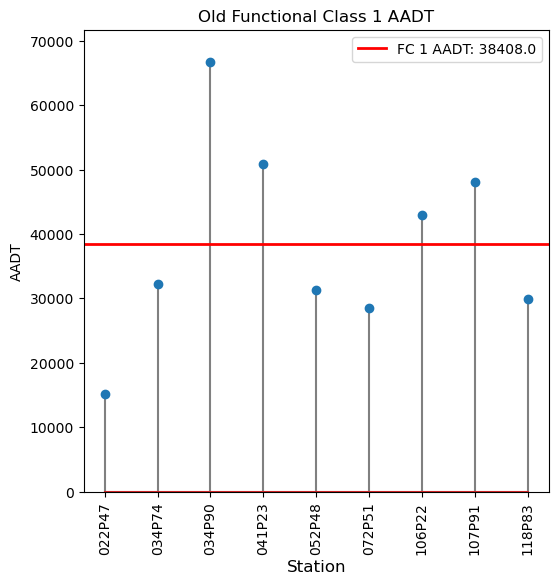

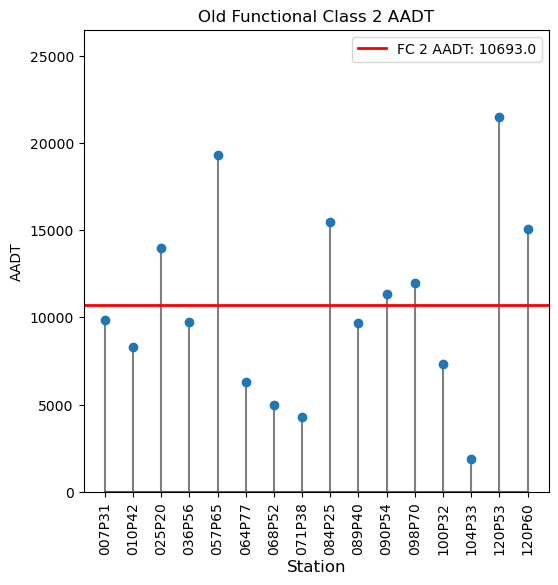

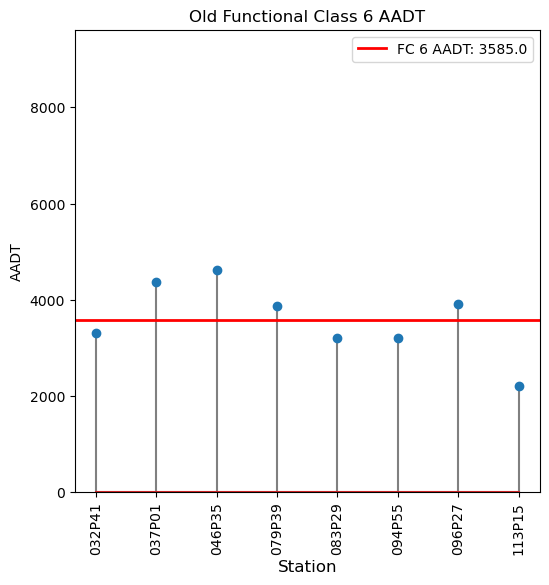

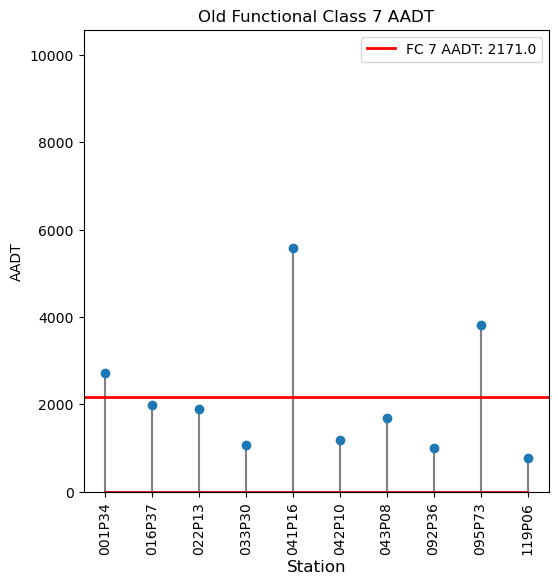

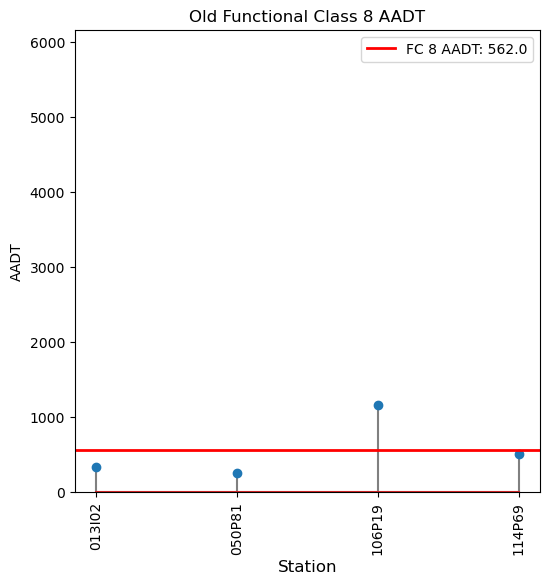

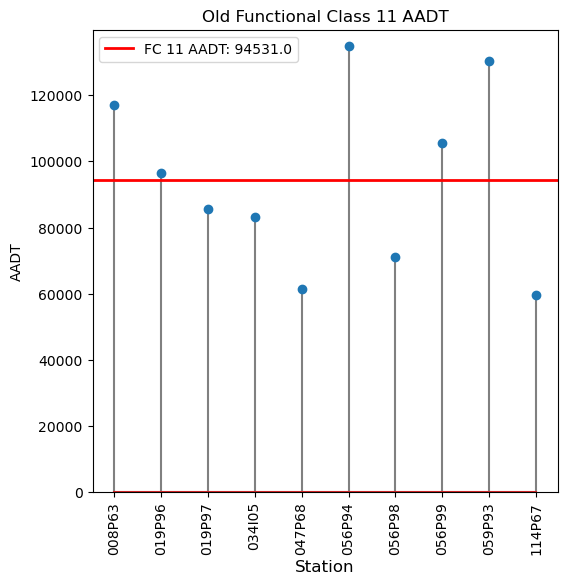

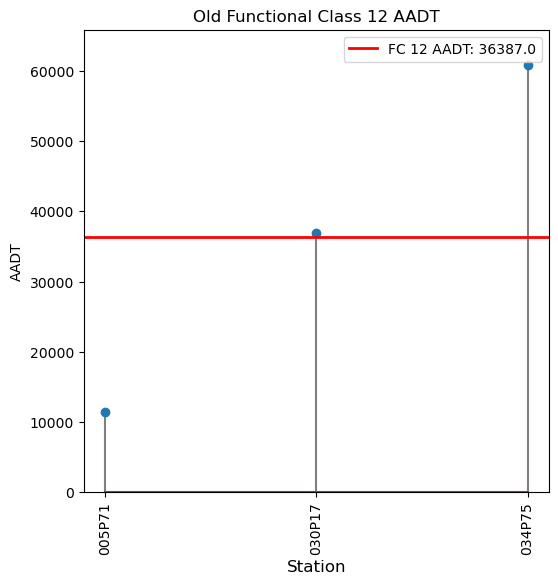

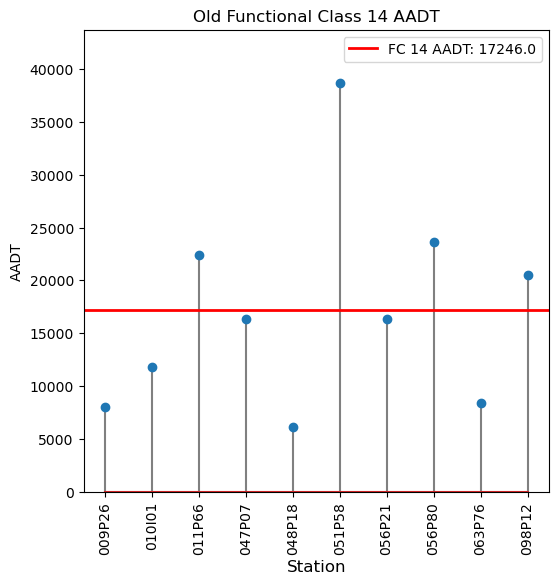

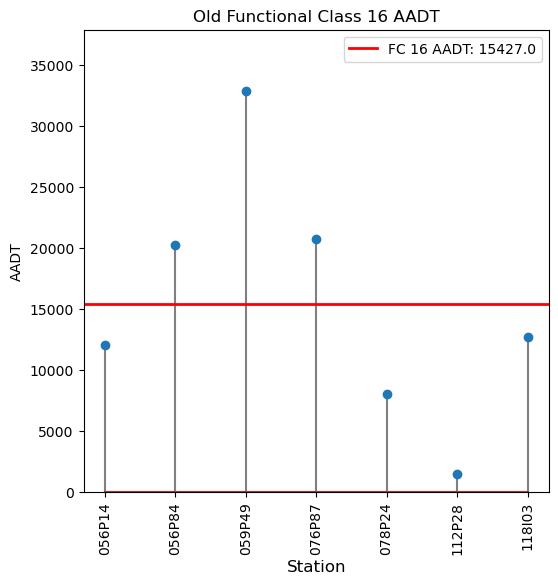

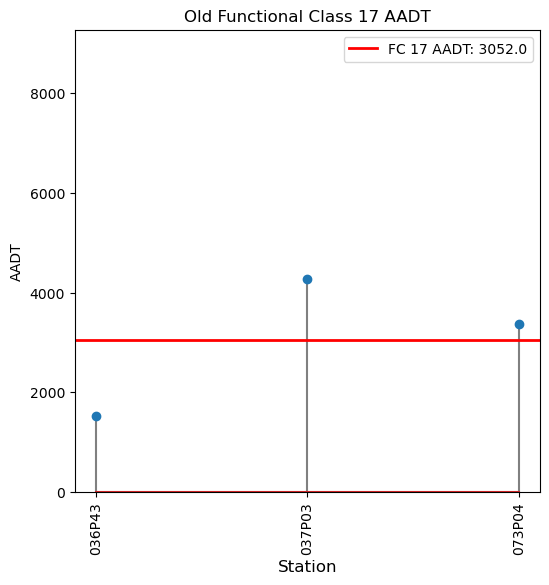

In [148]:
#Old FC
for fc in sorted(params.FC_Old.unique()):
    fig, ax = plt.subplots(figsize=(6, 6)) 
    df = params.loc[params.FC_Old == fc].reset_index(drop=True)
    adt = oldfc_params.loc[oldfc_params.FC_Old == fc].reset_index(drop=True)

    stations = df['Station']
    aadtstations = df['AADT']

    xr = range(0,len(df.index))
    (markers, stemlines, baseline) = plt.stem(aadtstations)
    plt.setp(stemlines, linestyle="-", color="grey", linewidth=1.5 )
    plt.xticks(xr, stations, rotation='vertical')
    plt.axhline(y=adt.AADT[0], color='r', linestyle='-', linewidth=2, label=f'FC {fc} AADT: {round(adt.AADT[0],0)}')
    plt.legend()
    plt.ylim(0, max(aadtstations)+5000)

    plt.xlabel('Station', fontsize=12)
    plt.ylabel('AADT')

    plt.title(f'Old Functional Class {fc} AADT')


    fname = f'FC_Old{fc}.png'
    plt.savefig(output_path + 'FC_Old plots/'+ fname, dpi = 1800, bbox_inches='tight')
    plt.show()

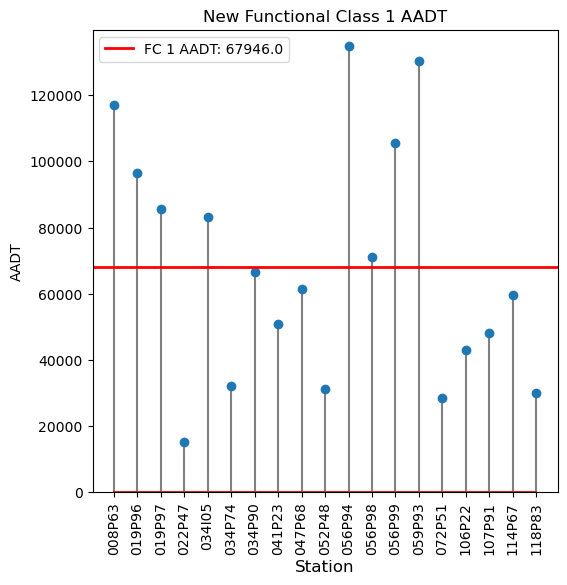

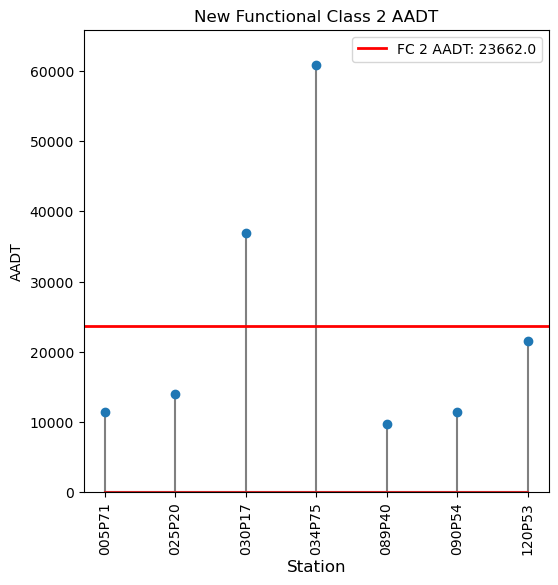

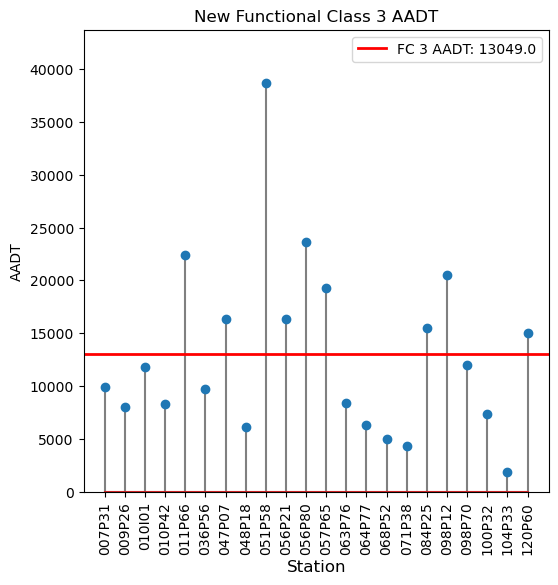

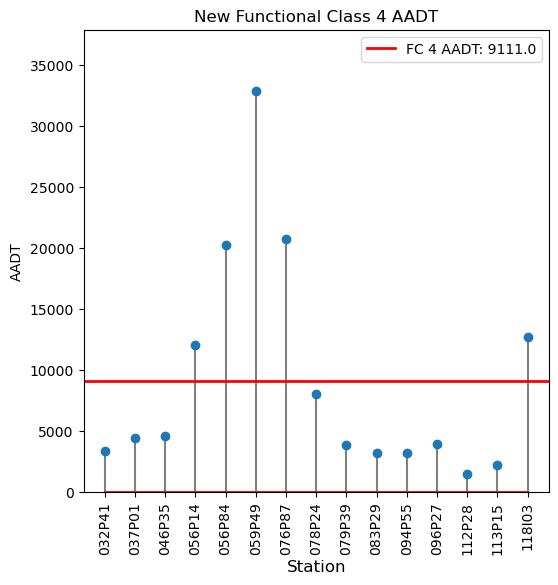

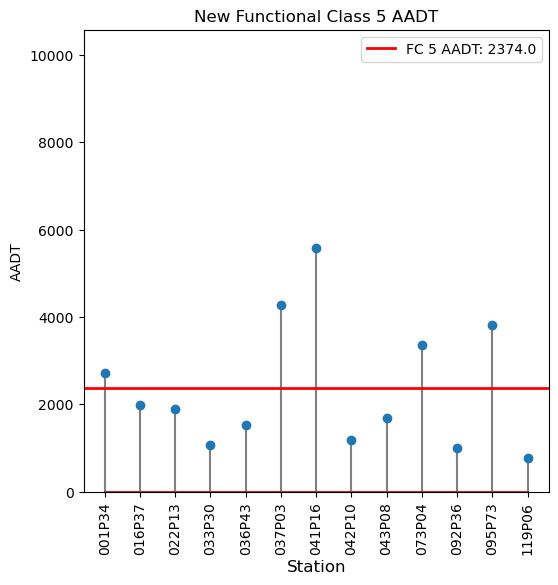

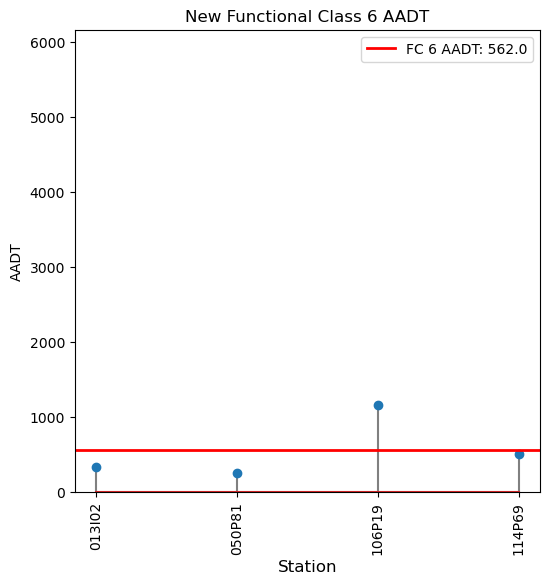

In [149]:
#New FC
for fc in sorted(params.FC_New.unique()):
    fig, ax = plt.subplots(figsize=(6, 6)) 

    df = params.loc[params.FC_New == fc].reset_index(drop=True)
    adt = newfc_params.loc[newfc_params.FC_New == fc].reset_index(drop=True)

    stations = df['Station']
    aadtstations = df['AADT']
    xr = range(0,len(df.index))
    (markers, stemlines, baseline) = plt.stem(aadtstations)
    plt.setp(stemlines, linestyle="-", color="grey", linewidth=1.5 )
    plt.xticks(xr, stations, rotation='vertical')
    plt.axhline(y=adt.AADT[0], color='r', linestyle='-', linewidth=2, label=f'FC {fc} AADT: {round(adt.AADT[0],0)}')
    plt.legend()
    plt.ylim(0, max(aadtstations)+5000)
    
    plt.xlabel('Station', fontsize=12)
    plt.ylabel('AADT')
    
    plt.title(f'New Functional Class {fc} AADT')
    
    
    fname = f'FC_New{fc}.png'
    plt.savefig(output_path + 'FC_New plots/'+ fname, dpi = 1800, bbox_inches='tight')
    plt.show()

### Hourly Volume Plots

In [150]:
hourly_newfc_volume.head(3)

,FC_New,hour,hourly_volume_percentage
0,1,0,1.241300
1,1,1,0.951297
2,1,2,0.861017


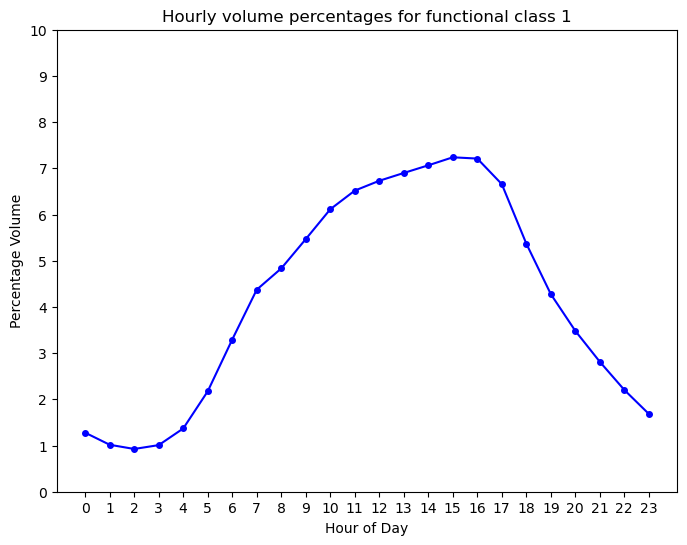

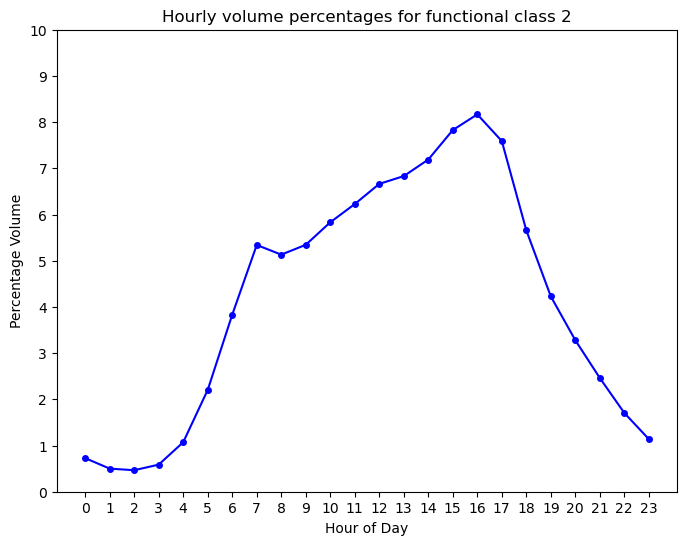

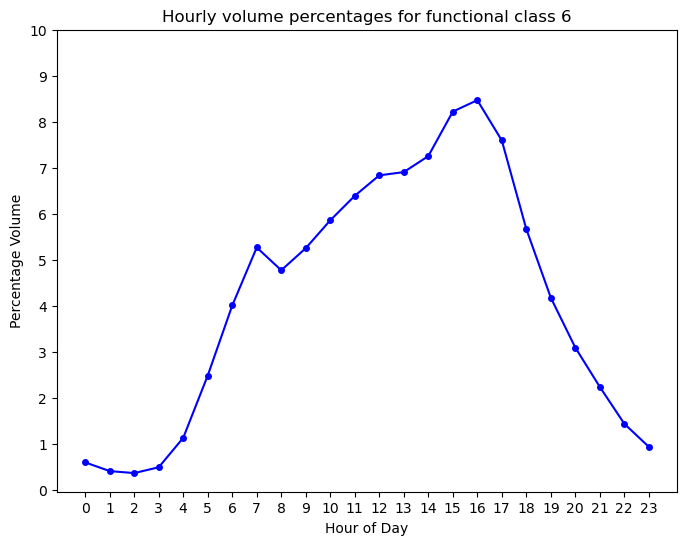

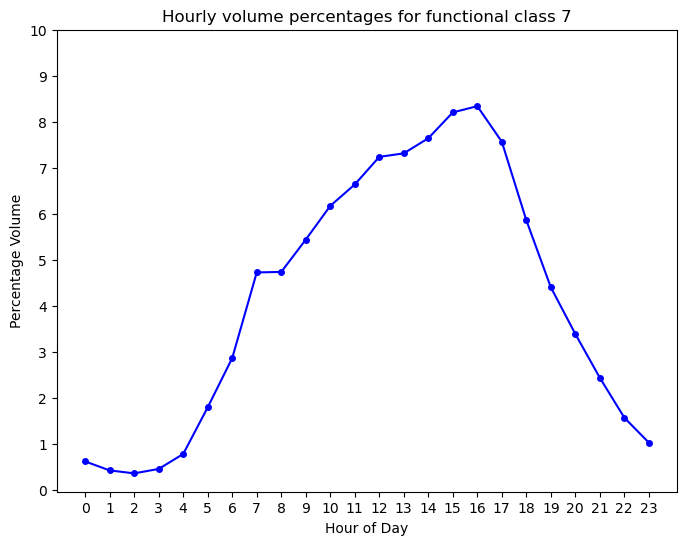

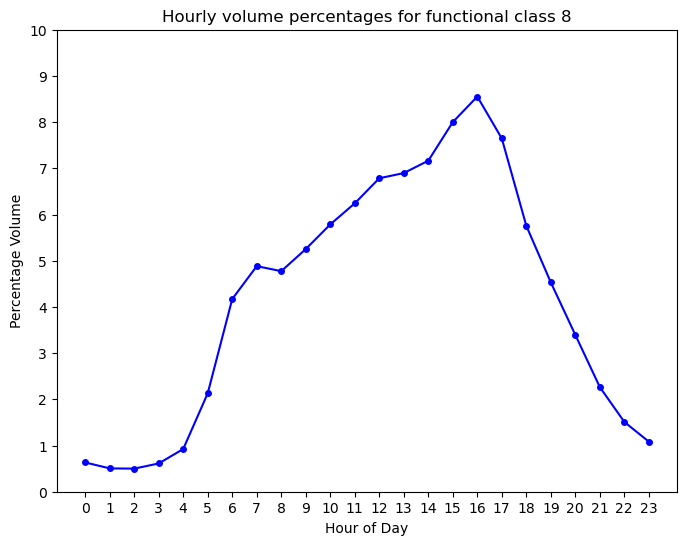

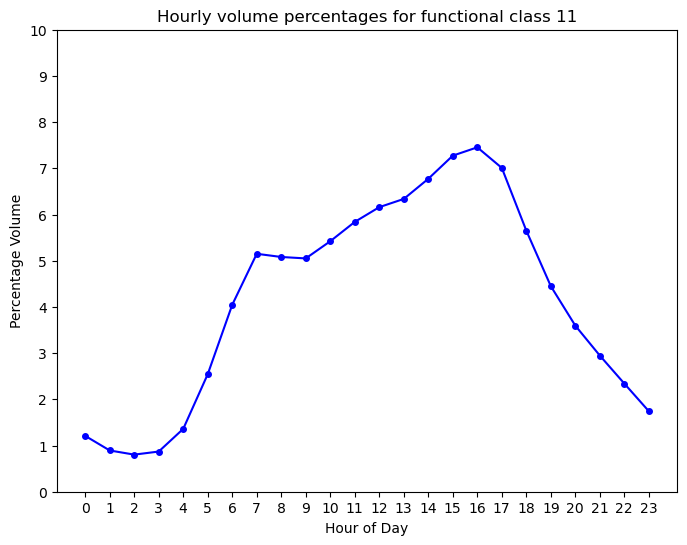

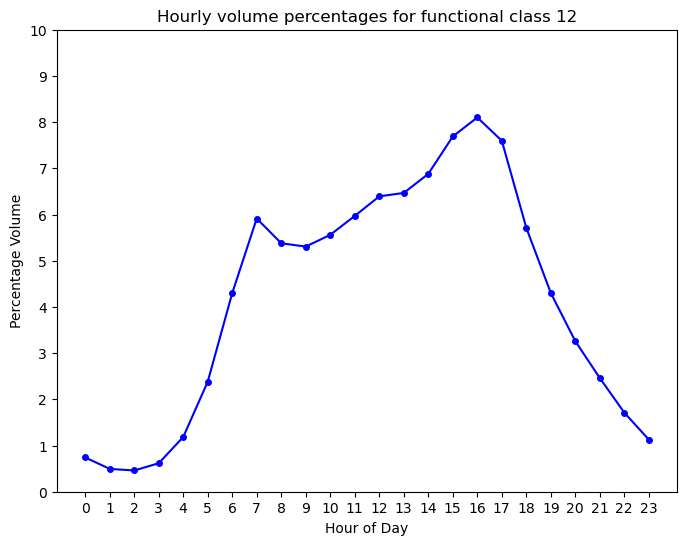

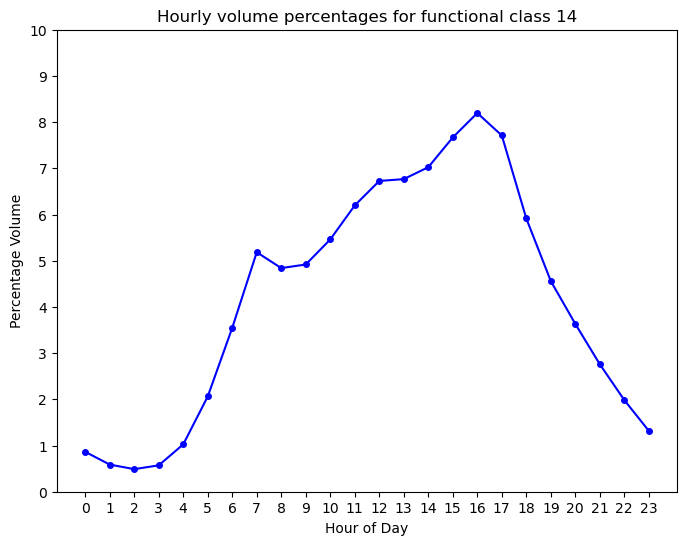

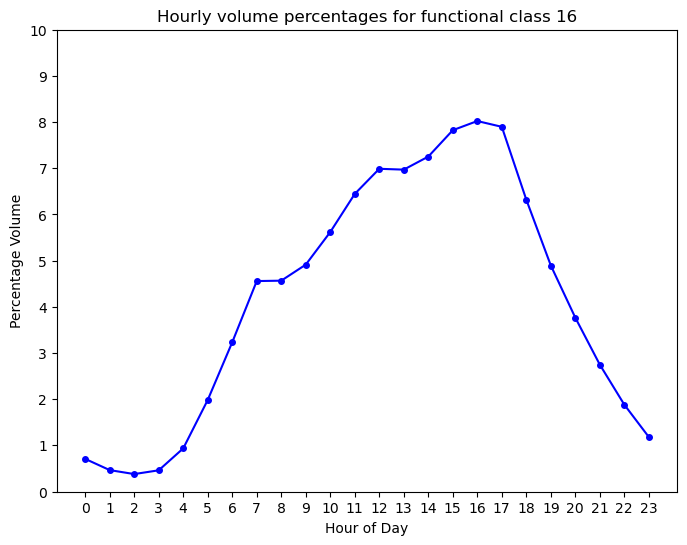

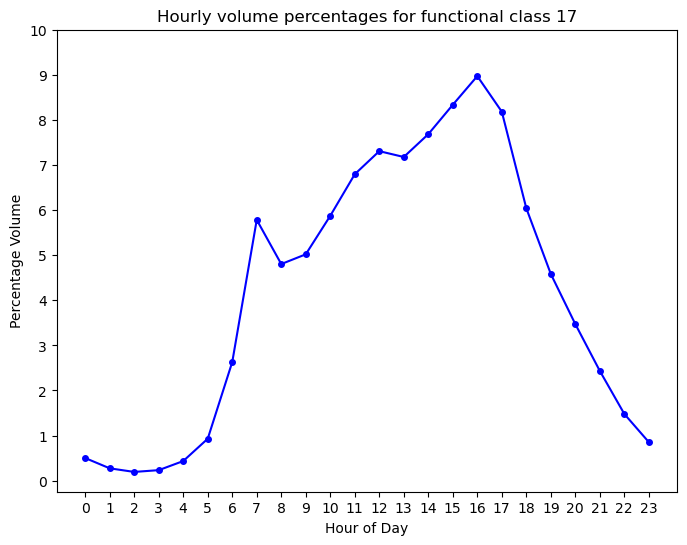

In [156]:
#fc_old
for fc in sorted(hourly_oldfc_volume.FC_Old.unique()):
    hour = [x for x in range(0,24)]

    fig, ax = plt.subplots(figsize=(8, 6)) 
    df = hourly_oldfc_volume[hourly_oldfc_volume.FC_Old == fc].reset_index(drop=True)
    x = hour
    y = df['hourly_volume_percentage']

    ax.plot(x, y, marker='o', color = 'blue', markersize=4,)
    ax.set_xticks(x)
    ax.set_yticks([x for x in range(0, 11)])
    plt.xlabel('Hour of Day')
    plt.ylabel('Percentage Volume')
    plt.title(f'Hourly volume percentages for functional class {fc}')
    fname = f'Hourly_volume_percentages_FC_{fc}.png'
    plt.savefig(output_path + 'FC_Old plots/'+ fname, dpi = 1800, bbox_inches='tight')
    plt.show()

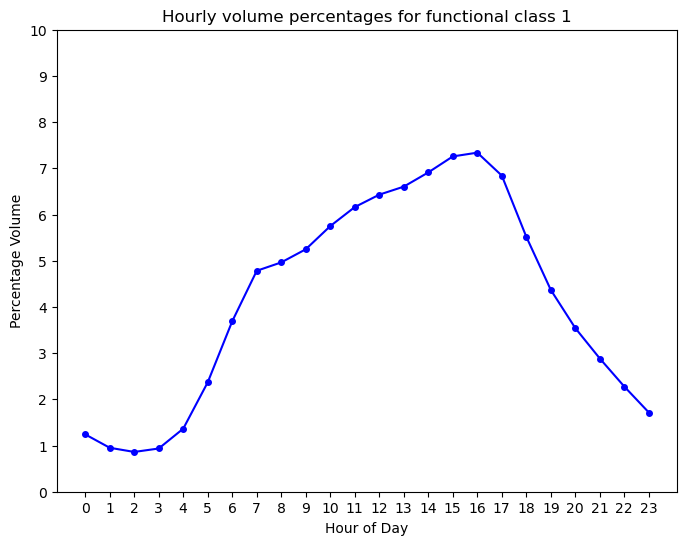

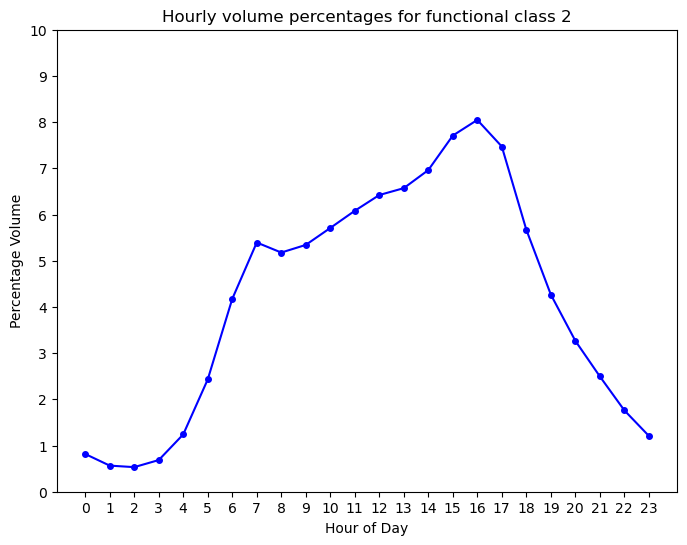

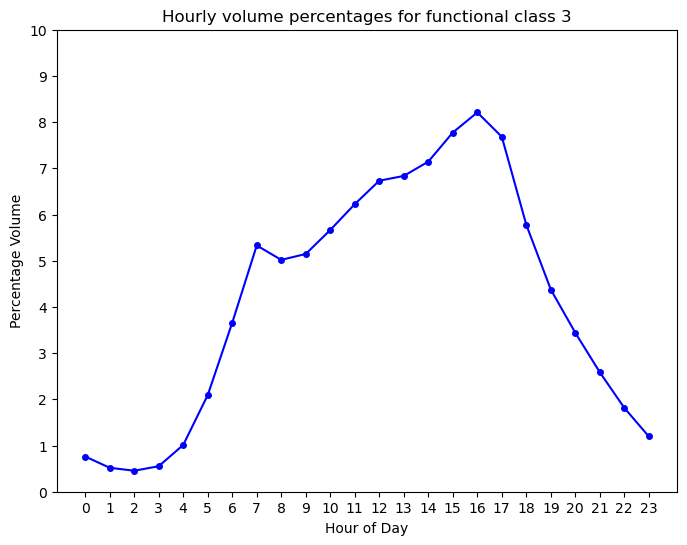

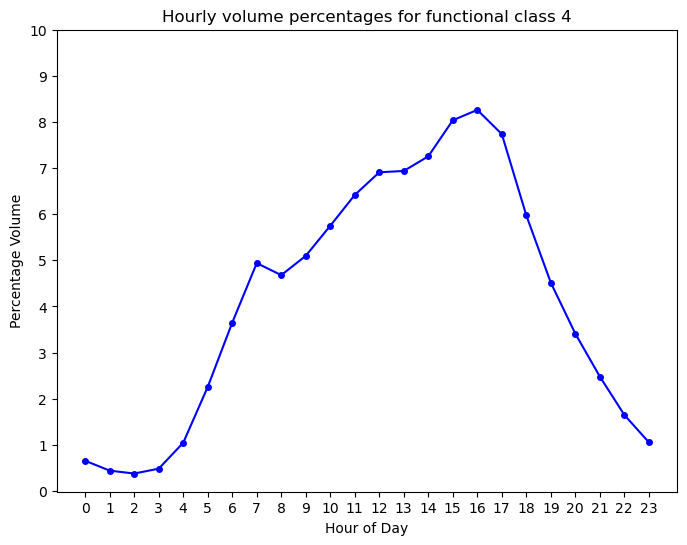

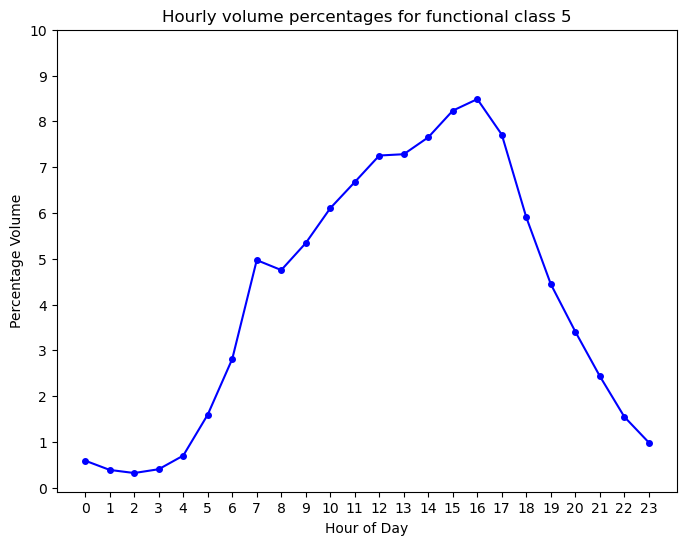

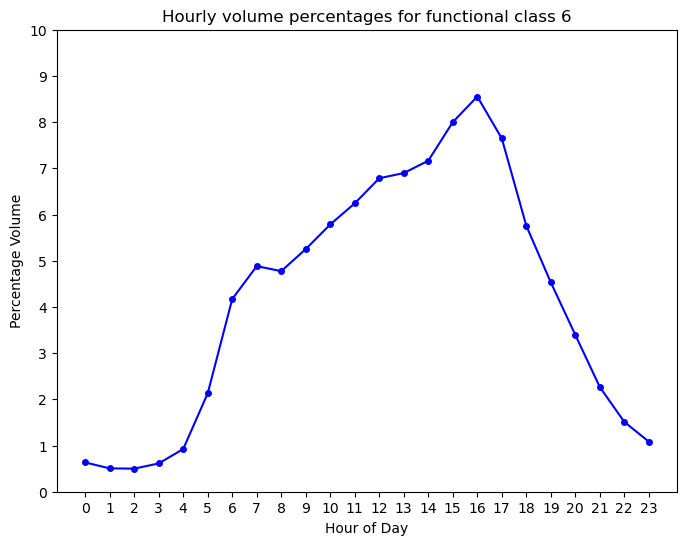

In [155]:
#fc_new
for fc in sorted(hourly_newfc_volume.FC_New.unique()):
    hour = [x for x in range(0,24)]

    fig, ax = plt.subplots(figsize=(8, 6)) 
    df = hourly_newfc_volume[hourly_newfc_volume.FC_New == fc].reset_index(drop=True)
    x = hour
    y = df['hourly_volume_percentage']

    ax.plot(x, y, marker='o', color = 'blue', markersize=4,)
    ax.set_xticks(x)
    ax.set_yticks([x for x in range(0, 11)])
    plt.xlabel('Hour of Day')
    plt.ylabel('Percentage Volume')
    plt.title(f'Hourly volume percentages for functional class {fc}')
    fname = f'Hourly_volume_percentages_FC_{fc}.png'
    plt.savefig(output_path + 'FC_New plots/'+ fname, dpi = 1800, bbox_inches='tight')
    plt.show()